<a href="https://colab.research.google.com/github/PINIX1101/TheGallerist/blob/main/Penerapan_Pembelajaran_Penguatan_pada_Permainan_Papan_The_Gallerist_(All_Agen).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import gym
from gym import Env
from gym.spaces import Discrete, MultiDiscrete
import tensorflow as tf
import os.path
from os import path
from math import ceil
from random import randint, sample, choice
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
import zipfile

In [ ]:
class stadef:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def random_choice(sample_size, probabilities):
    sample_index = []
    available_index = list(range(sample_size))
    for _ in range(sample_size):
        total_prob = np.sum(probabilities)
        if total_prob != 0:
            rand_val = random.random()*total_prob
        elif total_prob == 0:
            rand_val = random.random()
            probabilities = [1/len(available_index) for p in probabilities]
        cumulative_prob = 0.0
        for idx, prob in zip(available_index, probabilities):
            cumulative_prob += prob
            if rand_val <= cumulative_prob:
                delete_index = available_index.index(idx)
                sample_index.append(idx)
                probabilities = np.delete(probabilities,delete_index,0)
                available_index.pop(delete_index)
                break
    return sample_index

In [ ]:
def zip_folder(input_folder, output_zip):
    folder_path = os.path.abspath(input_folder)
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for foldername, subfolders, filenames in os.walk(folder_path):
            relative_folder = os.path.relpath(foldername, folder_path)
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                relative_file = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=os.path.join(relative_folder, filename))

def unzip_folder(input_zip, output_folder):
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        zip_ref.extractall(output_folder)


# 2. Environment


In [ ]:
class TheGallerist(Env):
################################################################################
# Variable Declaration #########################################################
    def __init__ (self,board_init,agent):
        self.agent = agent
        self.board_init = board_init
        self.board = 0
        self.player = 0
        self.first_player = 0
        self.action_history = [[] for i in range(len(self.agent))]
        self.total_round = 1
        self.move = 0

    def reset(self):
        del self.board
        del self.player
        self.first_player = (self.first_player + 1)%len(self.agent)
        self.reward = 0
        self.action_history = [[] for i in range(len(self.agent))]
        self.total_round = 1
        self.move = 0
        self.player_move = [0 for i in range(len(self.agent))]
        self.invalid_move = [0 for i in range(len(self.agent))]
        self.total_reward = [0 for i in range(len(self.agent))]

        def lobby_visitor(num_investors, num_vips, num_collectors, lobby):
            while True:
                a = randint(0,2)
                if a == 0 and num_investors > 0:
                    lobby.append(stadef(investors=1,vips=0,collectors=0))
                    num_investors += -1
                    break
                elif a == 1 and num_vips > 0:
                    lobby.append(stadef(investors=0,vips=1,collectors=0))
                    num_vips += -1
                    break
                elif a == 2 and num_collectors > 0:
                    lobby.append(stadef(investors=0,vips=0,collectors=1))
                    num_collectors += -1
                    break
            return lobby, num_investors, num_vips, num_collectors

        def art_visitor(number, num_investors, num_vips, num_collectors, art):
            while True:
                a = randint(0,2)
                if a == 0 and num_investors > 0:
                    art[number].visitor.investors += 1
                    num_investors += -1
                    break
                elif a == 1 and num_vips > 0:
                    art[number].visitor.vips += 1
                    num_vips += -1
                    break
                elif a == 2 and num_collectors > 0:
                    art[number].visitor.collectors += 1
                    num_collectors += -1
                    break
            return art[number], num_investors, num_vips, num_collectors

        def board_visitor(num_investors, num_vips, num_collectors, plaza):
            while True:
                a = randint(0,2)
                if a == 0 and num_investors > 0:
                    plaza.investors += 1
                    num_investors += -1
                    break
                elif a == 1 and num_vips > 0:
                    plaza.vips += 1
                    num_vips += -1
                    break
                elif a == 2 and num_collectors > 0:
                    plaza.collectors += 1
                    num_collectors += -1
                    break
            return plaza, num_investors, num_vips, num_collectors

        num_player = len(self.agent)
        if num_player == 1:
            num_ticket = 10
            num_investors = 10
            num_vips = 10
            num_collectors = 8
        else:
            num_ticket = 5*num_player
            num_investors = 6 + 2*num_player
            num_vips = 6 + 2*num_player
            num_collectors = 4 + 2*num_player

        executive = stadef(available=0,player=-1)
        kicked_out = stadef(available=0,player=-1,location=-1,assist=0)

        contract = []
        next_contract = sample(range(1,21),4)
        for i in range(4):
            contract.append(deepcopy(self.board_init.contract_set[next_contract[i]]))

        artist = []
        bonus = sample(range(10),8)
        for i in range(8):
            a = randint(0,1)
            artist.append(deepcopy(self.board_init.artist_set[a+2*i]))
            artist[i].bonus = self.board_init.artist_bonus_set[bonus[i]]
            if i%2 == 1:
                num_collectors += -1
                artist[i].collectors += 1
        dicovered = randint(0,3)
        artist[2*dicovered].discover = 1

        art = []
        for i in range(4):
            next_art = sample(range(8*i+1,8*i+9),1)
            art.append(deepcopy(self.board_init.art_set[next_art[0]]))
            for j in art[i].ticket:
                if j == 7:
                    art[i], num_investors, num_vips, num_collectors = art_visitor(i, num_investors, num_vips, num_collectors, art)
                    art[i], num_investors, num_vips, num_collectors = art_visitor(i, num_investors, num_vips, num_collectors, art)
                elif j > 0:
                    art[i], num_investors, num_vips, num_collectors = art_visitor(i, num_investors, num_vips, num_collectors, art)

        reputation_board = []
        reputation_player = []
        next_reputation = sample(range(22),16)
        for i in range(12):
            reputation_board.append(deepcopy(self.board_init.reputation_set[next_reputation[i]]))
        for i in range(12,16):
            reputation_player.append(deepcopy(self.board_init.reputation_set[next_reputation[i]]))
        reputation = []
        for i in range(12):
            if num_player <= 2 and i%3 == 1:
                reputation.append(stadef(available=0,player=-1,bonus=reputation_board[i]))
            else:
                reputation.append(stadef(available=1,player=-1,bonus=reputation_board[i]))

        offer = deepcopy(self.board_init.offer_set)

        art_offer = []
        next_art = sample(range(1,33),num_player-1)
        for i in range(num_player-1):
            art_offer.append(deepcopy(self.board_init.art_set[next_art[i]]))

        plaza = stadef(investors = 0,vips = 0, collectors = 0)
        for i in range(4):
            plaza, num_investors, num_vips, num_collectors = board_visitor(num_investors, num_vips, num_collectors, plaza)

        lobby = []
        for i in range(num_player):
            lobby, num_investors, num_vips, num_collectors = lobby_visitor(num_investors, num_vips, num_collectors, lobby)

        location = stadef(current=[-1,-1,-1,-1],assist=[-1,-1,-1,-1],bonus=[0,0,0,0])
        for i in range(4):
            location.bonus[i] = reputation_player[i]

        self.board = stadef(num_player=num_player,first_player=self.first_player,current_player=self.first_player,
                        last_round=0,first_round=1,intermediate_scoring=0,executive=executive,
                        kicked_out=kicked_out,plaza=plaza,lobby=lobby,brown_ticket=num_ticket,
                        red_ticket=num_ticket,white_ticket=num_ticket,investors=num_investors,
                        vips=num_vips,collectors=num_collectors,artist=artist,
                        contract_set=self.board_init.contract_set,contract=contract,
                        art_set=self.board_init.art_set,art=art,art_offer=art_offer,
                        location=location,offer=offer,reputation=reputation)

        art = []
        for i in range(4):
            art.append(deepcopy(self.board_init.art_set[0]))
        gallery = stadef(art=art,bonus=0,slot=3,celebrity=0)

        contract = []
        for i in range(3):
            contract.append(deepcopy(self.board_init.contract_set[0]))
            if i == 0:
                contract[i].bonus = 7
            elif i == 1:
                contract[i].bonus = 8
            else:
                contract[i].bonus = 9
        reputation = stadef(bonus=[1,2,3,4,5,6],placed=[0,0,0,0,0,0])

        curator = []
        next_curator = sample(range(4),4)
        for i in range(4):
            curator.append(deepcopy(self.board_init.curator_set[next_curator[i]]))
        dealer = []
        next_dealer = sample(range(4),4)
        for i in range(4):
            dealer.append(deepcopy(self.board_init.dealer_set[next_dealer[i]]))
        player_state = stadef(money=10,influence=10,brown_ticket=0,red_ticket=0,white_ticket=0,
                              investors=0,vips=0,collectors=0,assist_office=2,assist_unemployed=8,
                              gallery=gallery,sold=[0,0,0,0],signature=[0,0,0,0,0,0,0,0],commission=-1,
                              curator=0,dealer=0,contract=contract,reputation=reputation,current_action=-1)
        player = []
        for i in range(num_player):
            player.append(deepcopy(player_state))
            player[i].curator = curator[i]
            player[i].dealer = dealer[i]
        self.player = player
        return self._get_state()

    @property
    def visitor_money(self):
        current_player = self.board.current_player
        result = 2*self.player[current_player].investors + self.player[current_player].collectors
        return result

    @property
    def visitor_influence(self):
        current_player = self.board.current_player
        result = 2*self.player[current_player].vips + self.player[current_player].collectors
        return result

################################################################################
# Main Environment Function ####################################################
    def step(self):
        done = False
        num_player = self.board.num_player
        current_player = self.board.current_player
        for i in range(self.board.num_player):
            self.board.current_player = (self.board.first_player + i)%self.board.num_player
            terminate = self._take_action()
            if terminate:
                done = True
        if self.total_round >= 200:
            done = True
        if done:
            self.end_game_scoring()
        else:
            done = self._check_game_over()
        return done

    def _get_reward(self, before, after):
        current_player = self.board.current_player
        reward = 0
        if (after[0][0]-before[0][0]) > 0:
            reward += 2*0.1*(before[0][0]+1)*(after[0][0]-before[0][0])
        if (after[0][1]-before[0][1]) > 0:
            reward += 2*0.1*(before[0][1]+1)*(after[0][1]-before[0][1])
        if (after[0][2]-before[0][2]) > 0:
            reward += 2*0.1*(before[0][2]+1)*(after[0][2]-before[0][2])
        if (after[1][0]-before[1][0]) > 0:
            reward += 2*0.05*(before[1][0]+1)*(after[1][0]-before[1][0])
        if (after[1][1]-before[1][1]) > 0:
            reward += 2*0.05*(before[1][1]+1)*(after[1][1]-before[1][1])
        if (after[1][2]-before[1][2]) > 0:
            reward += 2*0.05*(before[1][2]+1)*(after[1][2]-before[1][2])
        if after[2][0] == 0 or after[2][0] == 4:
            if before[2][0] > 0 and before[2][0] < 4:
                reward += -0.1
        if before[2][0] == 0 or before[2][0] == 4:
            if after[2][0] > 0 and after[2][0] < 4:
                reward += 0.1
        reward += 0.2*(before[2][1]-after[2][1])
        if before[3][0] < 4:
            reward += 6*0.05*(before[3][0]+1)*(after[3][0]-before[3][0])
        if before[3][1] < 4:
            reward += 10*0.05*(before[3][1]+1)*(after[3][1]-before[3][1])
        if before[3][2] < 4:
            reward += 15*0.05*(before[3][2]+1)*(after[3][2]-before[3][2])
        reward += 1*(after[4]-before[4])
        if (after[5]-before[5]) > 0:
            reward += 6*0.1*(after[5]-before[5])
        reward += 1.0*(after[6]-before[6])
        reward += abs(5*0.1*(after[7]-before[7]))
        reward += after[8]
        if (after[9]-before[9]) > 0:
            reward += 0.2*(after[9]-before[9])
        return reward

    def _take_action(self):
        current_player = self.board.current_player
        reward = 0
        if self.board.first_round == 1:
            for i in range(8,12):
                if self.first_round_validation(i,[]):
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.first_round_validation,self.first_round,19,[],[])
                    break

        if self.executive_possible_validation() and self.board.first_round == 0 and self.board.last_round == 0:
            for i in range(3,5):
                if self.executive_action_validation(i,[]):
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.executive_action_validation,self.executive_action,14,[],[])
                    break

        if self.board.first_round == 0:
            move = 0
            for i in range(0,8):
                if self.location_action_validation(i,[0]):
                    move += 1
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.location_action_validation,self.location_action,0,[0],[0])
                    break
            if move == 0:
                self.invalid_move[current_player] += 1
                if self.count_ticket(self.board,['brown_ticket','red_ticket','white_ticket']) > 0:
                    self.banish_ticket()
                elif self.count_visitor(self.board,['investors','vips','collectors']) > 0:
                    self.move_visitor_to_plaza()
                next_state, next_condition = self.standard_action(self.agent[current_player],self.no_move_validation,self.no_move,30,[],[])

        if self.executive_possible_validation and self.board.first_round == 0 and self.board.last_round == 0:
            for i in range(3,5):
                if self.executive_action_validation(i,[]):
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.executive_action_validation,self.executive_action,14,[],[])
                    break

        if self.board.kicked_out.available == 1 and self.board.first_round == 0 and self.board.last_round == 0:
            self.board.current_player = self.board.kicked_out.player
            current_player = self.board.current_player
            move = 0
            for i in range(0,2):
                if self.kicked_out_validation(i,[]):
                    next_state, next_condition = self.standard_action(self.agent[0],self.kicked_out_validation,self.kicked_out,13,[],[])
                    move += 1
                    break
            if move == 0:
                self.action_history[current_player].append(['kicked_out',2])
            if self.board.kicked_out.assist == 1 and self.player[current_player].assist_office < 4:
                self.player[current_player].assist_office += 1
            self.board.kicked_out.available = 0
            self.board.kicked_out.player = -1
            self.board.kicked_out.location = -1
            self.board.kicked_out.assist = -1
        return False

    def _get_state(self):
        current_player = self.board.current_player
        state = []

        state.append(self.player[current_player].money)
        state.append(self.player[current_player].influence)
        state.append(self.player[current_player].brown_ticket)
        state.append(self.player[current_player].red_ticket)
        state.append(self.player[current_player].white_ticket)
        state.append(self.player[current_player].investors)
        state.append(self.player[current_player].vips)
        state.append(self.player[current_player].collectors)
        state.append(self.player[current_player].assist_office)
        state.append(self.player[current_player].assist_unemployed)
        state += [1 if self.player[current_player].commission == i else 0 for i in range(8)]
        state += [1 if self.player[current_player].current_action == i else 0 for i in range(31)]
        art_artist_count = [0 for i in range(8)]
        for i in range(4):
            art_artist_count[self.player[current_player].gallery.art[i].artist] += 1
        state += art_artist_count
        for i in range(4):
            state.append(self.player[current_player].sold[i])

        state += [1 if self.player[current_player].curator.number == i else 0 for i in range(4)]
        state += [1 if self.player[current_player].dealer.number == i else 0 for i in range(4)]

        contract_count = [0 for i in range(21)]
        for i in range(3):
            contract_count[self.player[current_player].contract[i].number] += 1
        state += contract_count
        state += [1 if self.player[current_player].reputation.bonus[i] > 0 else 0 for i in range(6)]

        state.append(self.board.num_player)
        state.append(1 if current_player == self.board.first_player else 0)
        state.append(1 if True == self.board.executive.available else 0)
        state.append(1 if current_player == self.board.kicked_out.player else 0)
        state += [1 if i == self.board.kicked_out.location else 0 for i in range(4)]
        state.append(self.board.first_round)
        state.append(self.board.last_round)
        state.append(self.board.intermediate_scoring)

        state.append(self.board.plaza.investors)
        state.append(self.board.plaza.vips)
        state.append(self.board.plaza.collectors)

        count_investors = 0
        count_vips = 0
        count_collectors = 0
        for i in range(self.board.num_player):
            if i == current_player:
                state.append(self.board.lobby[i].investors)
                state.append(self.board.lobby[i].vips)
                state.append(self.board.lobby[i].collectors)
            else:
                count_investors += self.count_visitor(self.board.lobby[i],['investors'])
                count_vips += self.count_visitor(self.board.lobby[i],['vips'])
                count_collectors += self.count_visitor(self.board.lobby[i],['collectors'])

        state.append(count_investors)
        state.append(count_vips)
        state.append(count_collectors)

        state.append(self.board.brown_ticket)
        state.append(self.board.red_ticket)
        state.append(self.board.white_ticket)

        for i in range(8):
            state.append(self.board.artist[i].thumb)
            state.append(self.board.artist[i].fame)
            state.append(self.board.artist[i].current_star)
            state.append(self.board.artist[i].discover)

        contract_count = [0 for i in range(21)]
        for i in range(4):
            contract_count[self.board.contract[i].number] += 1
        state += contract_count

        for i in range(4):
            state.append(self.board.art[i].fame)
            state += [1 if self.board.art[i].ticket == j else 0 for j in range(8)]
            state.append(self.board.art[i].visitor.investors)
            state.append(self.board.art[i].visitor.vips)
            state.append(self.board.art[i].visitor.collectors)

        art_count = [0,0,0,0]
        for i in range(self.board.num_player-1):
            art_count[self.board.art_offer[i].category-1] += 1
        state += art_count

        state += [1 if self.board.location.current[i] == current_player else 0 for i in range(4)]
        state += [1 if self.board.location.current[i] == current_player and self.board.location.assist[i] == 1 else 0 for i in range(4)]

        for i in range(9):
            state.append(self.board.offer[i].available)
            state.append(1 if self.board.offer[i].player == current_player else 0)

        for i in range(12):
            state.append(self.board.reputation[i].available)
            state.append(1 if self.board.reputation[i].player == current_player else 0)
        reputation_count = [0 for i in range(21)]
        for i in range(12):
            reputation_count[self.board.reputation[i].bonus] += 1
        state += reputation_count
        result = np.array(state)
        return result

    def _check_game_over(self):
        end_condition = 0

        if self.count_ticket(self.board,['brown_ticket','red_ticket','white_ticket']) <= 0:
            end_condition += 1

        if self.count_visitor(self.board,['investors','vips','collectors']) <= 0:
            end_condition += 1

        celebrity = 0
        for i in range(8):
            if self.board.artist[i].celebrity == 1:
                celebrity += 1
        if celebrity >= 2:
            end_condition += 1

        for ticket in ['brown_ticket','red_ticket','white_ticket']:
            if self.count_ticket(self.board,[ticket]) <= 0 and self.board.intermediate_scoring == 0:
                for i in range(self.board.num_player):
                    self.player[i].money += 2*self.player[i].investors + self.player[i].collectors
                    self.player[i].influence += 2*self.player[i].vips + self.player[i].collectors
                    self.board.intermediate_scoring = 1
                break

        if end_condition >= 2 and self.board.last_round == 1:
            self.end_game_scoring()
            print('game over')
            return True
        elif end_condition >= 2:
            self.board.last_round = 1
        elif self.board.first_round == 1:
            self.board.first_round = 0
            for i in range(4):
                self.board.location.bonus[i] = 0
        self.total_round += 1
        self.board.executive.available = 1
        return False

    def render(self):
        pass

    def currency_validation(self):
        current_player = self.board.current_player
        for key,value in self.player[current_player].__dict__.items():
            if type(value) == int:
                if value < 0 and key != 'commission' and key != 'current_action':
                    raise Exception("there is something wrong: currency below zero")
            if key == 'assist_office':
                if value > 4:
                    raise Exception("there is something wrong: assist office > 4")
        if self.board.investors < 0:
            raise Exception("there is something wrong: currency below zero")
        elif self.board.vips < 0:
            raise Exception("there is something wrong: currency below zero")
        elif self.board.collectors < 0:
            raise Exception("there is something wrong: currency below zero")
        if self.player[current_player].assist_office + self.player[current_player].assist_unemployed > 10:
            print('office = {}, unemployed = {}'.format(self.player[current_player].assist_office,self.player[current_player].assist_unemployed))
            raise Exception("there is something wrong: total assist > 10")

    def standard_action(self, agent, validation, action, current_action, *args):
        current_player = self.board.current_player
        self.player[current_player].current_action = current_action
        state_ = self._get_state()
        state = np.reshape(state_, [1, len(state_)])
        condition = self.reward_condition()
        validated = False
        while not validated:
            # print('current action = {}'.format(action.__name__))
            chosen = agent.act(state,validation,args[0])
            if chosen == 13:
                current_player = (self.board.current_player+self.board.num_player-1)%self.board.num_player
                print('round :',self.total_round)
                for key,value in self.board.__dict__.items():
                    if type(value) == int:
                        print('{} = {}'.format(key,value))
                print('board plaza :', vars(self.board.plaza))
                for i in range(self.board.num_player):
                    print('board lobby :', vars(self.board.lobby[i]))
                for i in self.board.reputation:
                    print('board reputation :', vars(i))
                for i in self.board.offer:
                    print('board offer :', vars(i))
                for i in self.board.lobby:
                    print('board lobby :', vars(i))
                for i in range(4):
                    print('board art :', vars(self.board.art[i]))
                for i in range(4):
                    print('board art visitor :', vars(self.board.art[i].visitor))
                print('board location :', vars(self.board.location))
                for i in range(4):
                    print('board contract :', vars(self.board.contract[i]))
                for i in range(8):
                    print('board artist :', vars(self.board.artist[i]))
                print('current_player = {}'.format(current_player))
                for key,value in self.player[current_player].__dict__.items():
                    if type(value) == int:
                        print('{} = {}'.format(key,value))
                print('player gallery :', vars(self.player[current_player].gallery))
                for i in range(4):
                    print('player gallery art :', vars(self.player[current_player].gallery.art[i]))
                for i in range(4):
                    print('player gallery visitor:', vars(self.player[current_player].gallery.art[i].visitor))
                for i in range(3):
                    print('player contract :', vars(self.player[current_player].contract[i]))
                print('player curator :', vars(self.player[current_player].curator))
                print('player dealer :', vars(self.player[current_player].dealer))
            elif chosen == 14:
                self.reset()
                break
            elif chosen == 15:
                print('no move')
                print('current action = {}'.format(action.__name__))
                reward = -10
                next_state = self._get_state()
                next_condition = self.reward_condition()
                raise Exception("there is something wrong: agent can't find valid move")
            elif validation(chosen,args[0]):
                self.move += 1
                self.player_move[current_player] += 1
                validated = True
                self.action_history[current_player].append([action.__name__,chosen])
                # print('current player = {}, current action = {}, action = {}, validated = {}'.format(current_player, action.__name__,chosen,validated))
                # action(chosen,args[1])
                next_state, next_condition = action(chosen,args[1])
                break
        next_state = np.reshape(next_state, [1, len(next_state)])
        reward = self._get_reward(condition, next_condition)
        self.total_reward[current_player] += reward
        done = False
        agent.remember(state, chosen, reward, next_state, done, 0)
        return state_, condition

################################################################################
# Non-action Function ##########################################################
    def reward_condition(self, add_reward = 0):
        current_player = self.board.current_player
        investors = self.count_visitor(self.player[current_player],['investors'])
        vips = self.count_visitor(self.player[current_player],['vips'])
        collectors = self.count_visitor(self.player[current_player],['collectors'])
        visitor = [investors, vips, collectors]
        brown_ticket = self.count_ticket(self.player[current_player],['brown_ticket'])
        red_ticket = self.count_ticket(self.player[current_player],['red_ticket'])
        white_ticket = self.count_ticket(self.player[current_player],['white_ticket'])
        ticket = [brown_ticket, red_ticket, white_ticket]
        assist = [self.player[current_player].assist_office, self.player[current_player].assist_unemployed]
        market_column = [0,0,0]
        for i in range(12):
            if self.board.reputation[i].player == current_player:
                if i % 3 == 1:
                    market_column[0] += 1
                elif i % 3 == 2:
                    market_column[1] += 1
                elif i % 3 == 0:
                    market_column[2] += 1
        for j in range(9):
            if self.board.reputation[i].player == current_player:
                if i % 3 == 1:
                    market_column[0] += 1
                elif i % 3 == 2:
                    market_column[1] += 1
                elif i % 3 == 0:
                    market_column[2] += 1

        art_sold = 0
        for i in range(4):
            art_sold += self.player[current_player].sold[i]

        art_star = 0
        for i in range(4):
            if self.player[current_player].gallery.art[i].category > 0:
                artist = self.player[current_player].gallery.art[i].artist
                art_star += self.board.artist[artist].current_star
        money = self.player[current_player].money

        art_match = 0
        exclude_contract = []
        for i in range(4):
            category = self.player[current_player].gallery.art[i].category
            for j in range(3):
                if j not in exclude_contract:
                    if category > 0 and self.player[current_player].contract[j].category == category:
                        exclude_contract.append(j)
                        art_match += 1

        influence = self.player[current_player].influence
        return visitor, ticket, assist, market_column, art_sold, art_star, money, art_match, add_reward, influence

    def count_reputation(self):
        current_player = self.board.current_player
        count = 0
        for i in range(12):
            if self.board.reputation[i].player == current_player:
                count += 1
        return count

    def count_offer(self):
        current_player = self.board.current_player
        count = 0
        for i in range(9):
            if self.board.offer[i].player == current_player:
                count += 1
        return count

    def count_visitor(self,location,arr_visitor):
        count = 0
        for visitor in arr_visitor:
            count += getattr(location,visitor)
        return count

    def count_ticket(self,location,arr_ticket):
        count = 0
        for ticket in arr_ticket:
            count += getattr(location,ticket)
        return count

    def move_visitor(self,current,target,visitor):
        current_visitor = getattr(current, visitor)
        if current_visitor > 0:
            target_visitor = getattr(target, visitor)
            setattr(current, visitor, current_visitor-1)
            setattr(target, visitor, target_visitor+1)

    def end_game_scoring(self):
        num_player = self.board.num_player
        current_player = self.board.current_player
        condition = []
        state = []
        for i in range(num_player):
            self.board.current_player = i
            current_player = self.board.current_player
            condition.append(self.reward_condition())
            state_ = self._get_state()
            state.append(np.reshape(state_, [1, len(state_)]))

        reputation_column = []
        for i in range(3):
            reputation_column.append([0,0,0,0])

        for i in range(12):
            if i%3 == 1:
                player = self.board.reputation[i].player
                if player >= 0:
                    reputation_column[0][player] += 1
            elif i%3 == 2:
                player = self.board.reputation[i].player
                if player >= 0:
                    reputation_column[1][player] += 1
            elif i%3 == 0:
                player = self.board.reputation[i].player
                if player >= 0:
                    reputation_column[2][player] += 1
        for i in range(9):
            if i%3 == 1:
                player = self.board.offer[i].player
                if player >= 0:
                    reputation_column[0][player] += 1
            elif i%3 == 2:
                player = self.board.offer[i].player
                if player >= 0:
                    reputation_column[1][player] += 1
            elif i%3 == 0:
                player = self.board.offer[i].player
                if player >= 0:
                    reputation_column[2][player] += 1

        rank_reputation = []
        for i in range(3):
            rank_reputation.append(sorted(range(len(reputation_column[i])), key=reputation_column[i].__getitem__, reverse=True))

        reputation_end_bonus = [[8,3,1],[10,6,3],[15,10,6]]
        for i in range(3):
            if num_player >= 3:
                if reputation_column[i][rank_reputation[i][0]] == reputation_column[i][rank_reputation[i][1]] and reputation_column[i][rank_reputation[i][1]] == reputation_column[i][rank_reputation[i][2]]:
                    reputation_end_bonus[i][0] = (reputation_end_bonus[i][0] + reputation_end_bonus[i][1] + reputation_end_bonus[i][2])//3
                    reputation_end_bonus[i][1] = reputation_end_bonus[i][0]
                    reputation_end_bonus[i][2] = reputation_end_bonus[i][0]
                elif reputation_column[i][rank_reputation[i][0]] == reputation_column[i][rank_reputation[i][1]]:
                    reputation_end_bonus[i][0] = (reputation_end_bonus[i][0] + reputation_end_bonus[i][1])//2
                    reputation_end_bonus[i][1] = reputation_end_bonus[i][0]
                elif reputation_column[i][rank_reputation[i][1]] == reputation_column[i][rank_reputation[i][2]]:
                    reputation_end_bonus[i][1] = (reputation_end_bonus[i][1] + reputation_end_bonus[i][2])//2
                    reputation_end_bonus[i][2] = reputation_end_bonus[i][1]
                for j in range(3):
                    if reputation_column[i][rank_reputation[i][j]] > 0:
                        self.player[rank_reputation[i][j]].money += reputation_end_bonus[i][j]
            elif num_player == 2:
                if reputation_column[i][rank_reputation[i][0]] == reputation_column[i][rank_reputation[i][1]]:
                    reputation_end_bonus[i][0] = (reputation_end_bonus[i][0] + reputation_end_bonus[i][1])//2
                    reputation_end_bonus[i][1] = reputation_end_bonus[i][0]
                if i != 1:
                    for j in range(2):
                        if reputation_column[i][rank_reputation[i][j]] > 0:
                            self.player[rank_reputation[i][j]].money += reputation_end_bonus[i][j]
            elif num_player == 1:
                if i != 1 and reputation_column[i][rank_reputation[i][0]] > 0:
                    self.player[rank_reputation[i][0]].money += reputation_end_bonus[i][0]

        for i in range(num_player):
            for j in range(6):
                bonus = self.player[i].reputation.placed[j]
                self.reputation_bonus(bonus,i)

        for i in range(num_player):
            for j in range(4):
                if self.player[i].gallery.art[j].category > 0:
                    current_artist = self.player[i].gallery.art[j].artist
                    current_star = self.board.artist[current_artist].current_star
                    if current_star == 6:
                        self.player[i].money += 20
                    elif current_star == 5 :
                        self.player[i].money += 17
                    elif current_star == 4:
                        self.player[i].money += 14
                    elif current_star == 3:
                        self.player[i].money += 11
                    elif current_star == 2:
                        self.player[i].money += 8
                    elif current_star == 1:
                        self.player[i].money += 5
                    else:
                        self.player[i].money += 0

        offer = []
        for i in range(num_player):
            offer.append([0,0,0,0,i])
        for i in range(9):
            if i//3 == 0:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][0] += 1
            elif i//3 == 1:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][0] += 3
            elif i//3 == 2:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][0] += 6
            if i%3 == 0:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][1] += 1
            elif i%3 == 2:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][2] += 1
            elif i%3 == 1:
                player = self.board.offer[i].player
                if player >= 0:
                    offer[player][3] += 1

        rank_offer = sorted(offer, key=lambda x: (x[0], x[1], x[2], x[3], x[4]), reverse=True)
        for i in range(num_player-1):
            if rank_offer[i][0] != 0:
                player = rank_offer[i][4]
                self.board.current_player = player
                next_state, next_condition = self.standard_action(self.agent[current_player],self.art_offer_validation,self.art_offer,28,[player],[player])

        # Dealer
        for i in range(num_player):
            for j in range(3):
                count = True
                for k in range(4):
                    if self.player[i].sold[k] < self.player[i].dealer.category_set[j][k]:
                        count = False
                        break
                if count:
                    if j == 0:
                        self.player[i].money += 5
                    elif j == 1:
                        self.player[i].money += 10
                    elif j == 2:
                        self.player[i].money += 10

        # Curator
        for i in range(num_player):
            for j in range(2):
                count = True
                for k in range(4):
                    art_count = 0
                    for l in range(4):
                        if self.player[i].gallery.art[l].category == (k+1):
                            art_count += 1
                    if art_count >= self.player[i].curator.category_set[j][k]:
                        count = False
                        break
                if count:
                    if j == 0:
                        self.player[i].money += 10
                    elif j == 1:
                        self.player[i].money += 15

        # influence
        influence_bonus = [[0,0],[1,1],[4,2],[8,3],[12,4],[15,5],[18,6],[20,7],[22,8],[24,9],[26,10],
                 [27,11],[28,12],[29,13],[30,14],[31,15],[32,16],[33,17],[34,18],[35,20]]
        for i in range(num_player):
            for influence in influence_bonus:
                if self.player[i].influence >= influence[0]:
                    bonus = influence[1]
            self.player[i].money += bonus

        next_condition = []
        next_state = []
        for i in range(num_player):
              self.board.current_player = i
              current_player = self.board.current_player
              next_condition.append(self.reward_condition())
              next_state_ = self._get_state()
              next_state.append(np.reshape(next_state_, [1, len(next_state_)]))

        for i in range(num_player):
              self.board.current_player = i
              current_player = self.board.current_player
              reward = self._get_reward(condition[current_player], next_condition[current_player])
              state_ = state[current_player]
              chosen_ = self.action_history[current_player][-1][1]
              next_state_ = next_state[current_player]
              self.agent[current_player].remember(state_, chosen_, reward, next_state_, True, 0)
              # print('{} reward {}'.format(current_player,reward))
              self.total_reward[current_player] += reward
              # print('total reward {}'.format(self.total_reward[current_player]))

        print('total round : {}'.format(self.total_round))

    def use_influence(self,total):
        current_player = self.board.current_player
        for i in range(total):
            if self.player[current_player].influence%5 == 0:
                self.player[current_player].influence += -5
            else:
                self.player[current_player].influence += -(self.player[current_player].influence%5)

    def get_ticket(self,category):
        current_player = self.board.current_player
        state = self._get_state()
        if category == 0:
            pass
        if category == 1: #brown
            if self.board.brown_ticket == 0:
                self.banish_ticket()
            else:
                self.board.brown_ticket += -1
            self.player[current_player].brown_ticket += 1
        elif category == 2: #red
            if self.board.red_ticket == 0:
                self.banish_ticket()
            else:
                self.board.red_ticket += -1
            self.player[current_player].red_ticket += 1
        elif category == 3: #white
            if self.board.white_ticket == 0:
                self.banish_ticket()
            else:
                self.board.white_ticket += -1
            self.player[current_player].white_ticket += 1
        elif category == 4: #bw
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_ticket_validation,self.pick_ticket,24,[1],[0])
        elif category == 5: #rw
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_ticket_validation,self.pick_ticket,25,[0],[0])
        elif category == 6: #brw
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_ticket_validation,self.pick_ticket,4,[3],[0])
        elif category == 7: #brw!=brw
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_ticket_validation,self.pick_ticket,4,[3],[1])

    def banish_ticket(self):
        while self.count_ticket(self.board,['brown_ticket','red_ticket','white_ticket']) > 0:
            ticket = randint(0,2)
            if ticket == 0:
                if self.board.brown_ticket > 0:
                    self.board.brown_ticket += -1
                    break
            elif ticket == 1:
                if self.board.red_ticket > 0:
                    self.board.red_ticket += -1
                    break
            elif ticket == 2:
                if self.board.white_ticket > 0:
                    self.board.white_ticket += -1
                    break

    def move_visitor_to_art(self,number):
        if number <= 3:
            while self.count_visitor(self.board,['investors','vips','collectors']) > 0:
                visitor = randint(0,2)
                if visitor == 0:
                    if self.count_visitor(self.board,['investors']) > 0:
                        self.move_visitor(self.board,self.board.art[number].visitor,'investors')
                        break
                elif visitor == 1:
                    if self.count_visitor(self.board,['vips']) > 0:
                        self.move_visitor(self.board,self.board.art[number].visitor,'vips')
                        break
                elif visitor == 2:
                    if self.count_visitor(self.board,['collectors']) > 0:
                        self.move_visitor(self.board,self.board.art[number].visitor,'collectors')
                        break

    def move_visitor_to_plaza(self):
        while self.count_visitor(self.board,['investors','vips','collectors']) > 0:
            visitor = randint(0,2)
            if visitor == 0:
                if self.count_visitor(self.board,['investors']) > 0:
                    self.move_visitor(self.board,self.board.plaza,'investors')
                    break
            elif visitor == 1:
                if self.count_visitor(self.board,['vips']) > 0:
                    self.move_visitor(self.board,self.board.plaza,'vips')
                    break
            elif visitor == 2:
                if self.count_visitor(self.board,['collectors']) > 0:
                    self.move_visitor(self.board,self.board.plaza,'collectors')
                    break

################################################################################
# Validation Function ##########################################################
    def put_art_offer_validation(self,number,args):
        number += -10
        if number >= 0 and number <= 1:
            current_player = args[0]
            if number == 0 and self.player[current_player].gallery.slot == 0:
                return False
            else:
                return True
        else:
            return False

    def art_offer_validation(self,number,args): #args[0] = player
        if number >= 0 and number <= (self.board.num_player-2):
            if self.board.art_offer[number].category > 0:
                return True
            else:
                return False
        else:
            return False

    def first_round_validation(self,number,args):
        number += -8
        if number >= 0 and number <= 3:
            current_player = self.board.current_player
            if self.board.location.current[number] >= 0:
                return False
            else:
                return True
        else:
            return False

    def assist_location_validation(self,number,args): #args[0] = previous location
        number += -10
        if number >= 0 and number <= 1:
            if args[0] >= 0:
                current_player = self.board.current_player
                previous_assist = -1
                for i in range(4):
                    if self.board.location.current[i] == current_player and self.board.location.assist[i] == 1:
                        previous_assist = i
                if number == 1 and previous_assist >= 0:
                    return True
                elif number == 1 and self.player[current_player].assist_office == 0:
                    return False
                return True
            else:
                return False
        else:
            return False

    def no_move_validation(self,number,args):
        # if number >= 0 and number <= 7:
        current_player = self.board.current_player
        previous_location = -1
        for i in range(4):
            if self.board.location.current[i] == current_player and self.board.location.assist[i] != 1:
                previous_location = i
        if previous_location == number//2 and self.board.location.assist[previous_location] == 0:
            return False
        return True
        # else:
        #     return False

    def location_action_validation(self,number,args): #args[0], 0 -> normal, 1 -> kicked
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            if args[0] == 1:
                if self.board.kicked_out.location != number//2 or self.player[current_player].influence == 0:
                    return False
            previous_location = -1
            for i in range(4):
                if self.board.location.current[i] == current_player and self.board.location.assist[i] != 1:
                    previous_location = i
            if previous_location == number//2 and self.board.location.assist[previous_location] == 0:
                return False
            if number == 0:
                for index in range(0,8):
                    if self.discover_artist_validation(index,[]):
                        return True
                return False
            elif number == 1:
                for index in range(0,8):
                    if self.buy_art_validation(index,[]):
                        return True
                return False
            elif number == 2:
                for index in range(0,5):
                    if self.sign_contract_validation(index,[1]):
                        return True
                return False
            elif number == 3:
                for index in range(4,12):
                    if self.sell_art_validation(index,[]):
                        return True
                return False
            elif number == 4:
                for index in range(8,12):
                    if self.hire_assist_validation(index,[True,args[0]]):
                        return True
                return False
            elif number == 5:
                for index in range(0,8):
                    if self.promote_artist_validation(index,[args[0]]):
                        return True
                return False
            elif number == 6:
                for index in range(0,12):
                    if self.market_validation(index,[0]):
                        return True
                return False
            else:
                for index in range(0,9):
                    if self.market_validation(index,[1]):
                        return True
                return False
        else:
            return False

    def kick_visitor_validation(self,number,args): #args[0] = location
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if args[0] == 0:
                location = self.player[current_player]
            elif args[0] == 1:
                location = self.board.lobby[current_player]
            count = 0
            count += self.count_visitor(location,['investors','vips','collectors'])
            if number == 0 and location.investors == 0 and count > 0:
                return False
            elif number == 1 and location.vips == 0 and count > 0:
                return False
            elif number == 2 and location.collectors == 0 and count > 0:
                return False
            else:
                return True
        else:
            return False

    def place_reputation_validation(self,number,args): #nothing
        number += -5
        if number >= 0 and number <= 5:
            current_player = self.board.current_player
            if self.player[current_player].reputation.placed[number] == 0:
                return True
            else:
                return False
        else:
            return False

    def put_contract_validation(self,number,args): #nothing
        number += -3
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if self.player[current_player].contract[number].category == 0:
                return True
            else:
                return False
        else:
            return False

    def sign_contract_validation(self,number,args): #nothing
        if number >= 0 and number <= 4:
            current_player = self.board.current_player
            if number == 4 and args[0] == 0:
                for contract in self.board.contract:
                    for art in self.player[current_player].gallery.art:
                        if contract.category == art.category:
                            return False
                return True
            else:
                for i in range(3):
                    if self.player[current_player].contract[i].category == 0:
                        for contract in self.board.contract:
                            if contract.category == (number+1):
                                return True
                return False
        else:
            return False

    def ticket_action_validation(self,number,args): #args[0] == ticket
        number += -9
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            player_ticket = getattr(self.player[current_player], args[0]) - number
            valid_visitor = 0
            if args[1] == 'collectors':
                valid_visitor += self.count_visitor(self.board.plaza, [args[1]])
                for i in range(self.board.num_player):
                    if i == current_player:
                        sold = 0
                        for j in range(4):
                            sold += self.player[current_player].sold[j]
                        valid_visitor += min(sold + 1 - self.player[current_player].collectors,self.count_visitor(self.board.lobby[i], [args[1]]))
                    else:
                        valid_visitor += 2*self.count_visitor(self.board.lobby[i], [args[1]])
            else:
                valid_visitor += 2*self.count_visitor(self.board.plaza, [args[1]])
                for i in range(self.board.num_player):
                    if i == current_player:
                        valid_visitor += self.count_visitor(self.board.lobby[i], [args[1]])
                    else:
                        valid_visitor += 3*self.count_visitor(self.board.lobby[i], [args[1]])
            valid_visitor += -number
            if player_ticket >= 0 and valid_visitor >= 0:
                return True
            else:
                return False
        else:
            return False

    def move_location_validation(self,number,args): #args[0] == visitor
        number += -6
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            num_player = self.board.num_player
            sold = 0
            for i in range(4):
                sold += self.player[current_player].sold[i]
            if number == 0 and self.count_visitor(self.board.lobby[current_player],[args[0]]) > 0:
                if args[0] == 'collectors' and self.player[current_player].collectors == sold + 1:
                    return False
                else:
                    return True
            elif number == 1 and self.count_visitor(self.board.plaza,[args[0]]) > 0:
                return True
            elif number == 2:
                count = 0
                for i in range(num_player):
                    if i != current_player:
                        count += self.count_visitor(self.board.lobby[i],[args[0]])
                if count > 0:
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def increase_fame_validation(self,number,args): #args[0] = total
        if number >= 0 and number <= 7 and self.board.artist[number].discover == 1:
            return True
        else:
            return False

    def executive_action_validation(self,number,args): #args[0]=nothing
        number += -3
        if number >= 0 and number <= 2:
            if number == 0: # contract bonus action
                for i in range(9,12):
                    if self.contract_bonus_validation(i,[]):
                        return True
                return False
            elif number == 1 and self.all_ticket_validation(): # ticket action
                return True
            elif number == 2: #pass
                return True
            else:
                return False
        else:
            return False

    def executive_possible_validation(self):
        if self.board.executive.available:
            for i in range(9,12):
                if self.contract_bonus_validation(i,[]):
                    return True
            if self.all_ticket_validation():
                return True
            return False
        else:
            return False

    def kicked_out_validation(self,number,args): #args = nothing
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if number == 0 and self.executive_possible_validation(): #executive action
                return True
            elif number == 1: #current location action
                location = self.board.kicked_out.location
                if self.location_action_validation(location*2,[1]):
                    return True
                elif self.location_action_validation(location*2+1,[1]):
                    return True
                return False
            elif number == 2: # pass
                return True
            else:
                return False
        else:
            return False

    def sell_art_validation(self,number,args):
        number += -4
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            for i in reversed(range(4)):
                if self.player[current_player].gallery.art[i].artist == number:
                    for contract in self.player[current_player].contract:
                        if contract.category == (number//2)+1:
                            return True
            return False
        else:
            return False

    def discover_artist_validation(self,number,args):
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            if self.board.artist[number].discover == 0 and self.player[current_player].commission == -1:
                return True
            else:
                return False
        else:
            return False

    def hire_assist_validation(self,number,args): #args[0] = pay
        number += -8
        if number >= 0 and number <= 3:
            if args[0]:
                assist_price = [1,2,2,3,3,4,5,6]
            else:
                assist_price = [0,0,0,0,0,0,0,0]
            current_player = self.board.current_player
            assist_valid = 4 - self.player[current_player].assist_office
            if args[1] == 0 and self.board.location.current[2] == current_player and self.board.location.assist[2] == 1:
                assist_valid += -1
            if args[1] == 1 and self.board.kicked_out.assist == 1 and self.board.kicked_out.player == current_player:
                assist_valid += -1
            if self.player[current_player].assist_unemployed < number + 1:
                return False
            if assist_valid >= number+1:
                total_price = 0
                for i in range(1,number+2):
                    current_unemployed = 8-self.player[current_player].assist_unemployed + i - 1
                    total_price += assist_price[current_unemployed]
                if self.player[current_player].money >= total_price:
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def promote_artist_validation(self,number,args): #nothing
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            if args[0] == 1:
                influence = self.player[current_player].influence
                if influence%5 == 0:
                    influence += -5
                else:
                    influence += -(influence%5)
            elif args[0] == 0:
                influence = self.player[current_player].influence
            artist = self.board.artist[number]
            if artist.thumb < 5 and (influence - (artist.thumb + 1) >= 0):
                return True
            else:
                return False
        else:
            return False

    def buy_art_validation(self,number,args): #args[0]=nothing
        if number >=0 and number <= 7:
            current_player = self.board.current_player
            artist = self.board.artist[number]
            if artist.discover == 1 and self.player[current_player].gallery.slot > 0 and artist.celebrity == 0:
                if self.player[current_player].commission == -1 and artist.signature > 0 and self.player[current_player].money >= artist.fame:
                    return True
                elif self.player[current_player].commission == number and self.player[current_player].money >= artist.start_fame:
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def market_validation(self,number,args):
        if number >= 0 and (args[0] == 0 or (args[0] == 1 and number <= 8)):
            condition = 0
            row = number//3
            column = number%3
            current_player = self.board.current_player
            assist = self.player[current_player].assist_office
            money = self.player[current_player].money
            sold = self.player[current_player].sold
            num_visitor = self.count_visitor(self.board.lobby[current_player],['investors','vips','collectors'])
            num_investors = self.board.lobby[current_player].investors
            num_vips = self.board.lobby[current_player].vips
            num_collectors = self.board.lobby[current_player].collectors
            num_vips_investors = self.count_visitor(self.board.lobby[current_player],['investors','vips'])
            if assist >= 1:
                condition += 1
            if column == 0 and num_visitor >= 1:
                condition += 1
            elif column == 1 and num_vips >= 1 and num_investors >= 1:
                condition += 1
            elif column == 2 and num_collectors >= 1 and num_vips_investors >= 1:
                condition += 1
            if args[0] == 0:
                for i in range(6):
                    if self.player[current_player].reputation.bonus[i] >= 1:
                        condition += 1
                        break
                if self.board.reputation[number].available == 1:
                    condition += 1
                if row == 0 and sold[0] >= 1:
                    condition += 1
                elif row == 1 and sold[1] >= 1:
                    condition += 1
                elif row == 2 and sold[2] >= 1:
                    condition += 1
                elif row == 3 and sold[3] >= 1:
                    condition += 1
            elif args[0] == 1:
                if self.board.offer[number].available == 1:
                    condition += 1
                if row == 0 and money >= 1:
                    condition += 1
                elif row == 1 and money >= 3:
                    condition += 1
                elif row == 2 and money >= 6:
                    condition += 1
            if args[0] == 0:
                if condition >= 5:
                    return True
                else:
                    return False
            elif args[0] == 1:
                if condition >= 4:
                    return True
                else:
                    return False
        else:
            return False

    def all_ticket_validation(self):
        current_player = self.board.current_player
        num_player = self.board.num_player
        for ticket in [['brown_ticket','investors'],['red_ticket','vips'],['white_ticket','collectors']]:
            player_ticket = getattr(self.player[current_player],ticket[0])
            board_visitor = 0
            for i in range(num_player):
                board_visitor += getattr(self.board.lobby[i],ticket[1])
            board_visitor += getattr(self.board.plaza,ticket[1])
            if (player_ticket > 0) and (board_visitor > 0):
                return True
        return False

    def all_contract_bonus_validation(self):
        current_player = self.board.current_player
        self.board.current_player
        assist = self.player[current_player].assist_office
        contract_bonus = 0
        for contract in self.player[current_player].contract:
            if contract.bonus <= 6:
                contract_bonus += contract.bonus
        if assist > 0 and contract_bonus > 0:
            return True
        else:
            return False

    def contract_bonus_validation(self,number,args): #nothing
        number += 9
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            assist = self.player[current_player].assist_office
            if assist > 0 and self.player[current_player].contract[number].bonus == 3:
                for i in range(3):
                    if self.player[current_player].contract[i].category == 0:
                        return True
                return False
            elif assist > 0 and self.player[current_player].contract[number].bonus > 0 and self.player[current_player].contract[number].bonus <= 6:
                return True
            else:
                return False
        else:
            return False

    def pick_visitor_validation(self,number,args):
        number += -6
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            sold = 0
            for i in range(4):
                sold += self.player[current_player].sold[i]
            if number == args[0]:
                return False
            elif number == 2 and self.player[current_player].collectors == sold + 1:
                return False
            else:
                return True
        else:
            return False

    def pick_ticket_validation(self,number,args):
        number += -9
        if number >= 0 and number <= 2:
            if number != args[0]:
                return True
            else:
                return False
        else:
            return False

################################################################################
# Bonus Function ###############################################################
    def activate_bonus(self, bonus_number):
        current_player = self.board.current_player
        if bonus_number == 0:
            pass
        elif bonus_number == 1:
            self.player[current_player].money += self.visitor_money
        elif bonus_number == 2:
            self.player[current_player].influence += self.visitor_influence
        elif bonus_number == 3:
            next_state, next_condition = self.standard_action(self.agent[current_player],self.sign_contract_validation,self.sign_contract,5,[0],[0])
        elif bonus_number == 4:
            if self.hire_assist_validation(0,[False,0]):
                self.hire_assist(0,[False])
        elif bonus_number == 5: #plaza investors vips
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_visitor_validation,self.pick_visitor,20,[2],[0])
        elif bonus_number == 6: #bag
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_visitor_validation,self.pick_visitor,21,[3],[1]) #semua visitor bisa

    def artist_bonus(self, bonus_number):
        current_player = self.board.current_player
        if bonus_number == 0:
            pass
        elif bonus_number == 1:
            self.activate_bonus(1)
        elif bonus_number == 2:
            self.activate_bonus(2)
        elif bonus_number == 3:
            next_state, next_condition = self.standard_action(self.agent[current_player],self.increase_fame_validation,self.increase_fame,22,[1],[1])
        elif bonus_number == 4:
            self.get_ticket(7)
        elif bonus_number == 5: #get visitor from plaza
            next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_visitor_validation,self.pick_visitor,23,[3],[0]) #semua visitor bisa

    def reputation_bonus(self,bonus_number, player):
        current_player = player
        if bonus_number == 0:
            pass
        elif bonus_number == 1:
            self.player[current_player].money += self.player[current_player].influence//3
        elif bonus_number == 2:
            self.player[current_player].money += 3*self.player[current_player].collectors
            self.player[current_player].influence += self.player[current_player].collectors
        elif bonus_number == 3:
            self.player[current_player].money += 2*self.player[current_player].vips
            self.player[current_player].influence += self.player[current_player].vips
        elif bonus_number == 4:
            self.player[current_player].money += 2*self.player[current_player].investors
            self.player[current_player].influence += self.player[current_player].investors
        elif bonus_number == 5:
            visitor = 0
            for ticket in [['brown_ticket','investors'],['red_ticket','vips'],['white_ticket','collectors']]:
                visitor += getattr(self.player[current_player],ticket[1])
            self.player[current_player].money += visitor
        elif bonus_number == 6:
            visitor_set = 0
            investors = self.player[current_player].investors
            vips = self.player[current_player].vips
            collectors = self.player[current_player].collectors
            while investors > 0 and vips > 0 and collectors > 0:
                self.player[current_player].money += 4
                investors += -1
                vips += -1
                collectors += -1
        elif bonus_number == 7:
            for reputation in self.player[current_player].reputation.placed:
                if reputation != 0:
                    self.player[current_player].money += 2
                    self.player[current_player].influence += 1
        elif bonus_number == 8:
            for offer in self.board.offer:
                if offer.player == current_player:
                    self.player[current_player].money += 3
                    self.player[current_player].influence += 1
        elif bonus_number == 9:
            self.player[current_player].money += 1*(10-self.player[current_player].assist_unemployed)
            self.player[current_player].influence += 1*(10-self.player[current_player].assist_unemployed)
        elif bonus_number == 10:
            for artist in self.board.artist:
                if artist.thumb >= 4:
                    self.player[current_player].money += 2
        elif bonus_number == 11:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category > 0:
                    count += 1
            for total in self.player[current_player].sold:
                count += total
            self.player[current_player].money += 2*count
        elif bonus_number == 12:
            count = 0
            for total in self.player[current_player].sold:
                count += total
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 13:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category > 0:
                    count += 1
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 14:
            art_complete = [0,0,0,0]
            for art in self.player[current_player].gallery.art:
                if art.category > 0:
                    art_complete[art.category-1] += 1
            for index in range(4):
                art_complete[index] += self.player[current_player].sold[index]
            for completed in art_complete:
                if completed > 0:
                    self.player[current_player].money += 2
                    self.player[current_player].influence += 1
        elif bonus_number == 15:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category == 1:
                    count += 1
            count += self.player[current_player].sold[0]
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 16:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category == 3:
                    count += 1
            count += self.player[current_player].sold[2]
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 17:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category == 4:
                    count += 1
            count += self.player[current_player].sold[3]
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 18:
            count = 0
            for art in self.player[current_player].gallery.art:
                if art.category == 2:
                    count += 1
            count += self.player[current_player].sold[1]
            self.player[current_player].money += 3*count
            self.player[current_player].influence += 1*count
        elif bonus_number == 19:
            for artist in self.board.artist:
                if artist.fame >= 15:
                    self.player[current_player].money += 2
                    self.player[current_player].influence += 1
        elif bonus_number == 20:
            count = 0
            for art in self.player[current_player].gallery.art:
                artist_number = art.artist
                if self.board.artist[artist_number].celebrity == 1:
                    count += 1
            self.player[current_player].money += 4*count
            self.player[current_player].influence += 2*count

################################################################################
# Action Function ##############################################################
    def no_move(self,number,args):
        current_player = self.board.current_player
        previous_location = -1
        for i in range(4):
            if self.board.location.current[i] == current_player and self.board.location.assist[i] != 1:
                previous_location = i
        if previous_location >= 0:
            self.board.location.current[previous_location] = -1
            self.board.location.assist[previous_location] = -1
        self.board.location.current[number//3] = current_player
        self.board.location.assist[number//3] = 0
        next_state = self._get_state()
        next_condition = self.reward_condition(add_reward = -20)
        return next_state, next_condition

    def put_art_offer(self,number,args):
        number += -10
        if number >= 0 and number <= 1:
            current_player = args[0]
            if number == 0:
                self.player[current_player].gallery.art[0] = deepcopy(self.board.art_offer[args[1]])
                art = self.player[current_player].gallery.art
                self.player[current_player].gallery.art = sorted(art, key=lambda x: (x.category))
            elif number == 1:
                category = self.board.art_offer[args[1]].category
                self.player[current_player].sold[category-1] += 1
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def art_offer(self,number,args): #args[0] = player
        if number >= 0 and number <= (self.board.num_player-2):
            artist = 2*(self.board.art_offer[number].category-1)
            if self.board.artist[artist].current_star >= self.board.artist[artist+1].current_star and self.board.artist[artist].discover == 1:
                current_star = self.board.artist[artist].current_star
            elif self.board.artist[artist].current_star < self.board.artist[artist+1].current_star and self.board.artist[artist+1].discover == 1:
                current_star = self.board.artist[artist+1].current_star
            else:
                current_star = 0
            if current_star == 6:
                self.player[args[0]].money += 20
            elif current_star == 5 :
                self.player[args[0]].money += 17
            elif current_star == 4:
                self.player[args[0]].money += 14
            elif current_star == 3:
                self.player[args[0]].money += 11
            elif current_star == 2:
                self.player[args[0]].money += 8
            elif current_star == 1:
                self.player[args[0]].money += 5
            else:
                self.player[args[0]].money += 0
            next_state, next_condition = self.standard_action(self.agent[args[0]],self.put_art_offer_validation,self.put_art_offer,29,[args[0]],[args[0],number])
            self.board.art_offer[number].category = 0
            return next_state, next_condition

    def first_round(self,number,args):
        number += -8
        if number >= 0 and number <= 3:
            current_player = self.board.current_player
            self.board.location.current[number] = current_player
            self.board.location.assist[number] = 0
            self.player[current_player].gallery.bonus = self.board.location.bonus[number]
            self.board.location.bonus[number] = 0
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def increase_fame(self,number,args): #args[0] = total fame
        if number >= 0 and number <= 7 and self.board.artist[number].discover == 1:
            current_player = self.board.current_player
            self.board.artist[number].fame += args[0]
            if self.board.artist[number].fame > 19:
                self.board.artist[number].fame = 19
            for index in range(len(self.board.artist[number].star)):
                if self.board.artist[number].fame >= self.board.artist[number].star[index]:
                    self.board.artist[number].current_star = index+1
                    if self.board.artist[number].current_star == 6 and self.board.artist[number].celebrity == 0:
                        for i in range(self.board.num_player):
                            for j in range(4):
                                if self.player[i].gallery.celebrity == 0 and self.player[i].gallery.art[j].artist == number:
                                    self.player[i].gallery.slot += 1
                                if self.player[i].gallery.art[j].artist == number:
                                    self.player[i].gallery.celebrity += 1
                        self.board.artist[number].celebrity == 1
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def pick_ticket(self,number,args):
        number += -9
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            self.get_ticket(number+1)
            if args[0] == 1:
                next_state, next_condition = self.standard_action(self.agent[current_player],self.pick_ticket_validation,self.pick_ticket,4,[number],[0])
            else:
                next_state = self._get_state()
                next_condition = self.reward_condition()
            return next_state, next_condition

    def hire_assist(self, number, args): #args[0] = pay
        number += -8
        if number >= 0 and number <= 3:
            if args[0]:
                assist_price = [1,2,2,3,3,4,5,6]
            else:
                assist_price = [0,0,0,0,0,0,0,0]
            current_player = self.board.current_player
            for i in range(1,number+2):
                current_unemployed = 8-(self.player[current_player].assist_unemployed)
                price = assist_price[current_unemployed]
                self.player[current_player].money += -price
                self.player[current_player].assist_unemployed += -1
                self.player[current_player].assist_office += 1
                if current_unemployed == 1:
                    if self.board.brown_ticket == 0:
                        self.banish_ticket()
                    else:
                        self.board.brown_ticket += -1
                    self.player[current_player].brown_ticket += 1
                elif current_unemployed == 2:
                    if self.board.red_ticket == 0:
                        self.banish_ticket()
                    else:
                        self.board.red_ticket += -1
                    self.player[current_player].red_ticket += 1
                elif current_unemployed == 3:
                    self.activate_bonus(2)
                elif current_unemployed == 5:
                    self.get_ticket(6)
                elif current_unemployed == 7:
                    self.activate_bonus(1)
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def pick_visitor(self,number,args):
        number += -6
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if args[0] == 0: #plaza
                if number == 0:
                    self.move_visitor(self.board.plaza,self.player[current_player],'investors')
                elif number == 1:
                    self.move_visitor(self.board.plaza,self.player[current_player],'vips')
                elif number == 2:
                    self.move_visitor(self.board.plaza,self.player[current_player],'collectors')
            elif args[0] == 1: #bag
                if number == 0:
                    self.move_visitor(self.board,self.player[current_player],'investors')
                elif number == 1:
                    self.move_visitor(self.board,self.player[current_player],'vips')
                elif number == 2:
                    self.move_visitor(self.board,self.player[current_player],'collectors')
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def kick_visitor_lobby(self,number,args): #args[0] = location
        if number >= 0 and number <= 2:
            ticket = [['brown_ticket','investors'],['red_ticket','vips'],['white_ticket','collectors']]
            current_player = self.board.current_player
            if self.count_visitor(self.board.lobby[current_player],[ticket[number][1]]) > 0:
                if number == 0:
                    self.move_visitor(self.board.lobby[current_player],self.board.plaza,'investors')
                elif number == 1:
                    self.move_visitor(self.board.lobby[current_player],self.board.plaza,'vips')
                else:
                    self.move_visitor(self.board.lobby[current_player],self.board.plaza,'collectors')
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def assist_location(self,number,args): #args[0] = previous location
        number += -10
        if number >= 0 and number <= 1:
            current_player = self.board.current_player
            if number == 1:
                previous_assist = -1
                for i in range(4):
                    if self.board.location.current[i] == current_player and self.board.location.assist[i] == 1:
                        previous_assist = i
                if previous_assist >= 0:
                    self.board.location.current[previous_assist] = -1
                    self.board.location.assist[previous_assist] = -1
                    self.board.location.current[args[0]] = current_player
                    self.board.location.assist[args[0]] = 1
                else:
                    self.player[current_player].assist_office += -1
                    self.board.location.current[args[0]] = current_player
                    self.board.location.assist[args[0]] = 1
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def location_action(self,number,args): #args[0] -> 0 normal, 1 kicked out
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            if args[0] == 0:
                if self.board.location.current[number//2] >= 0:
                    if self.board.location.current[number//2] != current_player:
                        self.board.kicked_out.player = self.board.location.current[number//2]
                        self.board.kicked_out.location = number//2
                        self.board.kicked_out.available = 1
                        if self.board.location.assist[number//2] == 1:
                            self.board.kicked_out.assist = 1
                        self.board.location.assist[number//2] = 0
                    if self.board.location.current[number//2] == current_player and self.board.location.assist[number//2] == 1 and self.player[current_player].assist_office < 4:
                        self.player[current_player].assist_office += 1
                previous_location = -1
                for i in range(4):
                    if self.board.location.current[i] == current_player and self.board.location.assist[i] != 1:
                        previous_location = i
                if previous_location >= 0:
                    self.board.location.current[previous_location] = -1
                    self.board.location.assist[previous_location] = -1
                self.board.location.current[number//2] = current_player
                self.board.location.assist[number//2] = 0
            elif args[0] == 1:
                self.use_influence(1)
            if number == 0: #(0 s/d 7)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.discover_artist_validation,self.discover_artist,2,[],[])
            elif number == 1: #buy art #(0 s/d 7)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.buy_art_validation,self.buy_art,3,[],[])
            elif number == 2: #sign_contract #(0 s/d 4)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.sign_contract_validation,self.sign_contract,5,[1],[1])
            elif number == 3: #sell art #(0 s/d 3)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.sell_art_validation,self.sell_art,7,[],[])
            elif number == 4: #hire_assist #agent(0 s/d 3) -> effect #(1 s/d 4)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.hire_assist_validation,self.hire_assist,8,[True,0],[True])
            elif number == 5: #promote_artist #(0 s/d 7)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.promote_artist_validation,self.promote_artist,9,[0],[0])
            elif number == 6: #take reputation #(0 s/d 11)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.market_validation,self.take_reputation,10,[0],[])
            elif number == 7: #make offer #(0 s/d 8)
                next_state, next_condition = self.standard_action(self.agent[current_player],self.market_validation,self.make_offer,12,[1],[])
            if args[0] == 0:
                if previous_location >= 0:
                    self.standard_action(self.agent[current_player],self.assist_location_validation,self.assist_location,1,[previous_location],[previous_location])
            return next_state, next_condition

    def sell_art(self,number,args): #nothing
        number += -4
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            for i in reversed(range(4)):
                if self.player[current_player].gallery.art[i].artist == number:
                    index = i
                    break
            current_star = self.board.artist[number].current_star
            self.player[current_player].gallery.slot += 1
            if current_star == 6:
                self.player[current_player].money += 20
            elif current_star == 5 :
                self.player[current_player].money += 17
            elif current_star == 4:
                self.player[current_player].money += 14
            elif current_star == 3:
                self.player[current_player].money += 11
            elif current_star == 2:
                self.player[current_player].money += 8
            elif current_star == 1:
                self.player[current_player].money += 5
            else:
                self.player[current_player].money += 0
            category = (number//2)+1
            self.player[current_player].sold[category-1] += 1
            self.player[current_player].gallery.art[index] = self.board.art_set[0]
            art = self.player[current_player].gallery.art
            self.player[current_player].gallery.art = sorted(art, key=lambda x: (x.category))
            found = 0
            self.player[current_player].signature[number] += -1
            self.board.artist[number].signature += 1
            for i in range(3): #flip contract
                if self.player[current_player].contract[i].category == category and self.player[current_player].contract[i].bonus == 0:
                    if self.player[current_player].assist_office < 4:
                        self.player[current_player].assist_office += 1
                    self.player[current_player].contract[i] = self.board.contract_set[0]
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.kick_visitor_validation,self.kick_visitor_gallery,26,[0],[i])
                    found += 1
                    break
            if found == 0:
                for i in range(3):
                    if self.player[current_player].contract[i].category == category:
                        self.player[current_player].contract[i] = self.board.contract_set[0]
                        next_state, next_condition = self.standard_action(self.agent[current_player],self.kick_visitor_validation,self.kick_visitor_gallery,26,[0],[i])
                        break
            return next_state, next_condition

    def kick_visitor_gallery(self,number,args): #args[0]=location
        if number >= 0 and number <= 2:
            name = 'kick visitor {} from gallery'.format(number)
            current_player = self.board.current_player
            if self.count_visitor(self.player[current_player],['investors','vips','collectors']) == 0:
                if self.player[current_player].investors >= self.player[current_player].vips:
                    self.player[current_player].contract[args[0]].bonus = 1
                else:
                    self.player[current_player].contract[args[0]].bonus = 2
            elif number == 0:
                self.move_visitor(self.player[current_player],self.board.plaza,'investors')
                self.player[current_player].contract[args[0]].bonus = 1
            elif number == 1:
                self.move_visitor(self.player[current_player],self.board.plaza,'vips')
                self.player[current_player].contract[args[0]].bonus = 2
            elif number == 2:
                self.move_visitor(self.player[current_player],self.board.plaza,'collectors')
                if self.player[current_player].investors >= self.player[current_player].vips:
                    self.player[current_player].contract[args[0]].bonus = 1
                else:
                    self.player[current_player].contract[args[0]].bonus = 2
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def buy_art(self,number,args): #args[0]=nothing
        if number >=0 and number <= 7:
            current_player = self.board.current_player
            if self.player[current_player].commission >= 0:
                self.player[current_player].money += -(self.board.artist[number].start_fame)
                self.player[current_player].commission = -1
            elif self.player[current_player].commission == -1:
                self.player[current_player].money += -(self.board.artist[number].fame)
                self.board.artist[number].signature += -1
            self.increase_fame(number,[self.player[current_player].collectors + self.board.art[number//2].fame])
            self.player[current_player].gallery.slot += -1
            for ticket in [['brown_ticket','investors'],['red_ticket','vips'],['white_ticket','collectors']]:
                while self.count_visitor(self.board.art[number//2].visitor,[ticket[1]]) > 0:
                    self.move_visitor(self.board.art[number//2].visitor,self.board.plaza,ticket[1])
            for i in range(2):
                self.get_ticket(self.board.art[number//2].ticket[i])
            for i in range(2):
                self.board.art[number//2].ticket[i] = 0
            self.player[current_player].gallery.art[0] = deepcopy(self.board.art[number//2])
            self.player[current_player].gallery.art[0].artist = number
            self.player[current_player].gallery.art[0].fame = self.board.artist[number].fame
            art = self.player[current_player].gallery.art
            self.player[current_player].gallery.art = sorted(art, key=lambda x: (x.category))
            if number//2 == 0:
                next_art = sample(range(1,9),1)
            elif number//2 == 1:
                next_art = sample(range(9,17),1)
            elif number//2 == 2:
                next_art = sample(range(17,25),1)
            elif number//2 == 3:
                next_art = sample(range(25,33),1)
            self.board.art[number//2] = deepcopy(self.board.art_set[next_art[0]])
            for i in range(2):
                if self.board.art[number//2].ticket[i] == 7:
                    self.move_visitor_to_art(number//2)
                    self.move_visitor_to_art(number//2)
                elif self.board.art[number//2].ticket[i] > 0:
                    self.move_visitor_to_art(number//2)
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def sign_contract(self,number,args): #draw
        if number >= 0 and number <= 4:
            state = self._get_state
            current_player = self.board.current_player
            if number == 4:
                if args[0] == 1:
                    next_contract = sample(range(1,21),4)
                    self.board.contract.clear()
                    for i in range(4):
                        self.board.contract.append(deepcopy(self.board.contract_set[next_contract[i]]))
                    contract = self.board.contract
                    self.board.contract = sorted(contract, key=lambda x: (x.category))
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.sign_contract_validation,self.sign_contract,5,[0],[0])
                else:
                    next_state = self._get_state()
                    next_condition = self.reward_condition(-1)
            elif number < 4:
                for i in range(4):
                    if self.board.contract[i].category == (number+1):
                        contract_index = i
                        break
                next_state, next_condition = self.standard_action(self.agent[current_player],self.put_contract_validation,self.put_contract,6,[],[contract_index])
                next_contract = sample(range(1,21),1)
                self.board.contract[contract_index] = deepcopy(self.board.contract_set[next_contract[0]])
                contract = self.board.contract
                self.board.contract = sorted(contract, key=lambda x: (x.category))
            return next_state, next_condition

    def put_contract(self,number,args): #nothing
        number += -3
        if number >= 0 and number <= 2:
            state = self._get_state()
            current_player = self.board.current_player
            if self.player[current_player].contract[number].bonus == 0:
                if self.player[current_player].assist_office < 4:
                    self.player[current_player].assist_office += 1
            elif self.player[current_player].contract[number].bonus == 7:
                self.get_ticket(1)
            elif self.player[current_player].contract[number].bonus == 8:
                self.get_ticket(2)
            elif self.player[current_player].contract[number].bonus == 9:
                self.get_ticket(6)
            self.player[current_player].contract[number] = deepcopy(self.board.contract[args[0]])
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def place_reputation(self,number,args): #nothing
        number += -5
        if number >= 0 and number <= 5:
            current_player = self.board.current_player
            if self.player[current_player].reputation.bonus[number] == 1:
                self.activate_bonus(2)
            elif self.player[current_player].reputation.bonus[number] == 2:
                self.activate_bonus(1)
            elif self.player[current_player].reputation.bonus[number] == 3:
                self.artist_bonus(3)
            elif self.player[current_player].reputation.bonus[number] == 4:
                self.artist_bonus(5)
            elif self.player[current_player].reputation.bonus[number] == 5:
                self.get_ticket(7)
            elif self.player[current_player].reputation.bonus[number] == 6:
                if self.hire_assist_validation(0,[False,0]):
                    self.hire_assist(0,[False])
            self.player[current_player].reputation.bonus[number] = 0
            self.player[current_player].reputation.placed[number] = deepcopy(self.board.reputation[args[0]].bonus)
            next_state, next_condition = self.standard_action(self.agent[current_player],self.kick_visitor_validation,self.kick_visitor_lobby,27,[1],[]) #(0 s/d 2)
            return next_state, next_condition

    def take_reputation(self,number,args): #nothing
        if number >= 0 and number <= 11:
            current_player = self.board.current_player
            row = number//3
            self.board.reputation[number].available = 0
            self.board.reputation[number].player = current_player
            self.player[current_player].assist_office += -1
            next_state, next_condition = self.standard_action(self.agent[current_player],self.place_reputation_validation,self.place_reputation,11,[],[number]) #(0 s/d 5)
            return next_state, next_condition

    def make_offer(self,number,args): #nothing
        if number >= 0 and number <= 8:
            current_player = self.board.current_player
            row = number//3
            column = number%3
            self.board.offer[number].available = 0
            self.board.offer[number].player = current_player
            bonus = self.board.offer[number].bonus
            if column == 0:
                self.player[current_player].influence = 3
            elif column == 1:
                self.player[current_player].influence = 2
            elif column == 2:
                self.player[current_player].influence = 1
            if row == 0:
                self.player[current_player].money += -1
            elif row == 1:
                self.player[current_player].money += -3
            elif row == 2:
                self.player[current_player].money += -6
            self.player[current_player].assist_office += -1
            if bonus == 1:
                self.get_ticket(6)
            elif bonus == 2:
                if self.hire_assist_validation(0,[False,0]):
                    self.hire_assist(0,[False])
            elif bonus == 3:
                self.get_ticket(7)
            elif bonus == 4:
                self.activate_bonus(2)
            elif bonus == 5:
                self.activate_bonus(1)
            elif bonus == 6:
                self.artist_bonus(5)
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def promote_artist(self,number,args): #nothing
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            self.player[current_player].influence += -(self.board.artist[number].thumb + 1)
            self.board.artist[number].thumb += 1
            self.increase_fame(number,[self.player[current_player].collectors + 1])
            if self.board.artist[number].thumb == 1:
                self.get_ticket(6)
            elif self.board.artist[number].thumb == 2:
                self.activate_bonus(2)
            elif self.board.artist[number].thumb == 3:
                self.get_ticket(7)
            elif self.board.artist[number].thumb == 4:
                self.activate_bonus(1)
            elif self.board.artist[number].thumb == 5:
                self.artist_bonus(5)
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def discover_artist(self,number,args): #args[0]=nothing
        if number >= 0 and number <= 7:
            current_player = self.board.current_player
            artist = self.board.artist[number]
            if artist.color == 1:
                self.move_visitor(self.board.artist[number],self.board.plaza,'collectors')
            self.board.artist[number].discover = 1
            self.player[current_player].signature[number] += 1
            self.player[current_player].commission = number
            self.board.artist[number].signature += -1
            self.artist_bonus(artist.bonus)
            self.board.artist[number].bonus = 0
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

################################################################################
# Executive Action #############################################################
    def contract_bonus(self,number,args): #args[0] = nothing
        number += 9
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            self.player[current_player].assist_office += -1
            bonus = self.player[current_player].contract[number].bonus
            self.activate_bonus(bonus)
            self.player[current_player].contract[number].bonus = 0
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def move_location_action(self,number,args): #args == visitor
        number += -6
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            num_player = self.board.num_player
            if number == 0: # current player lobby
                self.move_visitor(self.board.lobby[current_player],self.player[current_player],args[0])
            elif number == 1: # plaza
                self.move_visitor(self.board.plaza,self.board.lobby[current_player],args[0])
            elif number == 2: # other lobby
                for i in range(num_player):
                    if self.count_visitor(self.board.lobby[i],[args[0]]) > 0 and current_player != i:
                        self.move_visitor(self.board.lobby[i],self.board.plaza,args[0])
                        break
            next_state = self._get_state()
            next_condition = self.reward_condition()
            return next_state, next_condition

    def ticket_action(self,number,args): #args[0] = ticket, args[1] = visitor
        number += -9
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if args[0] == 'brown_ticket':
                self.player[current_player].brown_ticket += -int(number)
            elif args[0] == 'red_ticket':
                self.player[current_player].red_ticket += -int(number)
            elif args[0] == 'white_ticket':
                self.player[current_player].white_ticket += -int(number)
            next_state = self._get_state()
            next_condition = self.reward_condition()
            for iteration in range(number):
                if iteration == 0:
                    next_state, next_condition = self.standard_action(self.agent[current_player],self.move_location_validation,self.move_location_action,17,[args[1]],[args[1]])
                else:
                    self.standard_action(self.agent[current_player],self.move_location_validation,self.move_location_action,17,[args[1]],[args[1]])
            return next_state, next_condition

    def executive_action(self,number,args): #args[0] = nothing
        number += -3
        if number >= 0 and number <= 2:
            current_player = self.board.current_player
            if number == 0: #(0 s/d 2)
                self.board.executive.available = False
                next_state, next_condition = self.standard_action(self.agent[current_player],self.contract_bonus_validation,self.contract_bonus,15,[],[])
            elif number == 1: # ticket action
                self.board.executive.available = False
                count = 0
                for ticket in [['brown_ticket','investors'],['red_ticket','vips'],['white_ticket','collectors']]:
                    if getattr(self.player[current_player],ticket[0]) > 0:
                        if count == 0:
                            next_state, next_condition = self.standard_action(self.agent[current_player],self.ticket_action_validation,self.ticket_action,16,[ticket[0],ticket[1]],[ticket[0],ticket[1]])
                            count += 1
                        else:
                            self.standard_action(self.agent[current_player],self.ticket_action_validation,self.ticket_action,16,[ticket[0],ticket[1]],[ticket[0],ticket[1]])
            elif number == 2:
                next_state = self._get_state()
                next_condition = self.reward_condition()
            return next_state, next_condition

################################################################################
# Kick Out Action ##############################################################
    def kicked_out(self,number,args): #args[0] = nothing (0 s/d 2)
        if number >= 0 and number <= 2:
            self.board.current_player = self.board.kicked_out.player
            current_player = self.board.current_player
            if number == 0: #executive action
                next_state, next_condition = self.standard_action(self.agent[current_player],self.executive_action_validation,self.executive_action,14,[],[])
            elif number == 1: #current location action
                next_state, next_condition = self.standard_action(self.agent[current_player],self.location_action_validation,self.location_action,18,[1],[1]) # (0 s/d 8)
            elif number == 2:
                next_state = self._get_state()
                next_condition = self.reward_condition()
            return next_state, next_condition

# 3. Agent

In [ ]:
class metaAgent:
    def __init__ (self, name, state_size, action_size):
        self.name = name
        self.state_size = state_size
        self.action_size = action_size
        self.model_set = []
        self.memory = [[],[],[],[]]
        self.state_scaler = MinMaxScaler()
        max_state = [500,35,20,20,20,14,14,12,4,8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,
                50,50,50,50,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
                3,3,3,3,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,14,14,12,14,14,12,14,
                14,12,20,20,20,5,19,6,1,5,19,6,1,5,19,6,1,5,19,6,1,5,19,6,1,5,19,
                6,1,5,19,6,1,5,19,6,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,
                4,2,1,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,
                1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,2,2,2,3,3,3,3,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                1,1,1,1,1,1,1,1,1,1,12,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
        min_state = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        scaler = [max_state,min_state]
        self.state_scaler.fit(scaler)

In [ ]:
class DQNAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.2
        self.gamma = 0.95
        self.learning_rate = 0.001

        self.model = self._build_model(self.state_size, self.action_size, 'linear', hidden = 2)
        self.model_set.append([self.model,'model'])

    def _build_model(self, input_size, output_size, activation, hidden = 0):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_dim=(input_size), activation='relu'))
        for i in range(hidden):
            model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(tf.keras.layers.Dense(output_size, activation=activation))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr=self.learning_rate),metrics=['mae'])
        return model

    def act(self, state, validation, args):
        state = self.state_scaler.transform(state)
        if np.random.rand() <= self.epsilon:
            exclude = []
            for i in range(self.action_size):
                action = choice(list(set(range(self.action_size)) - set(exclude)))
                if validation(action,args):
                    return action
                else:
                    exclude.append(action)
        q_values = self.model.predict(state, verbose=0)[0]
        valid = np.argsort(q_values)[::-1]
        for action in valid:
            if validation(action,args):
                return action
        return 15

    def remember(self, state, action, reward, next_state, done, slot):
        state = self.state_scaler.transform(state)
        next_state = self.state_scaler.transform(next_state)
        self.memory[slot].append((state, action, reward, next_state, done))
        for i in range(4):
            if len(self.memory[i]) > 5000:
                self.memory[i] = self.memory[i][-5000:]

    def load(self, name):
      if int(name) <= 230:
          self.epsilon *= self.epsilon_decay**int(name)
      else:
          self.epsilon = self.epsilon_min
      if int(name) >= 500:
          self.learning_rate = self.learning_rate/(int(name)//500)
      for index in range(len(self.model_set)):
            self.model_set[index][0].load_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))
      for slot in range(4):
          try:
              df = pd.read_csv('./{}/{}/state-{}.csv'.format(name, self.name, slot))
              state = df.to_numpy()
              df = pd.read_csv('./{}/{}/action-{}.csv'.format(name, self.name, slot))
              action = df.to_numpy()
              df = pd.read_csv('./{}/{}/reward-{}.csv'.format(name, self.name, slot))
              reward = df.to_numpy()
              df = pd.read_csv('./{}/{}/next_state-{}.csv'.format(name, self.name, slot))
              next_state = df.to_numpy()
              df = pd.read_csv('./{}/{}/done-{}.csv'.format(name, self.name, slot))
              done = df.to_numpy()
              for i in range(len(reward)):
                  self.remember(np.reshape(state[i], [1, len(state[i])]), action[i][0], reward[i][0],
                                np.reshape(next_state[i], [1, len(next_state[i])]), done[i][0], slot)
          except:
              pass

    def save(self, name):
        if path.exists('./{}'.format(name)) == False:
            os.mkdir('./{}'.format(name))
        if path.exists('./{}/{}'.format(name, self.name)) == False:
            os.mkdir('./{}/{}'.format(name, self.name))
        for index in range(len(self.model_set)):
            self.model_set[index][0].save_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))
        for slot in range(4):
            state = []
            action = []
            reward = []
            next_state = []
            done = []
            for i in range(len(self.memory[slot])):
                state.append(self.memory[slot][i][0][0])
                action.append(self.memory[slot][i][1])
                reward.append(self.memory[slot][i][2])
                next_state.append(self.memory[slot][i][3][0])
                done.append(self.memory[slot][i][4])
            pd.DataFrame(state).to_csv('./{}/{}/state-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(action).to_csv('./{}/{}/action-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(reward).to_csv('./{}/{}/reward-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(next_state).to_csv('./{}/{}/next_state-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(done).to_csv('./{}/{}/done-{}.csv'.format(name, self.name, slot), index=False)

    def train(self):
        batch_size = 64
        loss = []
        for slot in range(4):
            if len(self.memory[slot]) > batch_size:
                loss_function = self.replay(batch_size,slot)
                loss.append(loss_function)
        return loss

    def replay(self, batch_size, slot):
        minibatch = random.sample(self.memory[slot], batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return [history.history["mae"][0]]

In [ ]:
class DDQNAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.2
        self.update_counter = 0
        self.max_update_counter = 5
        self.gamma = 0.95
        self.learning_rate = 0.001

        self.model = self._build_model(self.state_size, self.action_size, 'linear', hidden = 2)
        self.model_set.append([self.model,'model'])
        self.target_model = self._build_model(self.state_size, self.action_size, 'linear', hidden = 2)
        self.update_target_model()
        self.model_set.append([self.target_model,'target_model'])

    def _build_model(self, input_size, output_size, activation, hidden = 0):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_dim=(input_size), activation='relu'))
        for i in range(hidden):
            model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(tf.keras.layers.Dense(output_size, activation=activation))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr=self.learning_rate),metrics=['mae'])
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state, validation, args):
        state = self.state_scaler.transform(state)
        if np.random.rand() <= self.epsilon:
            exclude = []
            for i in range(self.action_size):
                action = choice(list(set(range(self.action_size)) - set(exclude)))
                if validation(action,args):
                    return action
                else:
                    exclude.append(action)
        q_values = self.model.predict(state, verbose=0)[0]
        valid = np.argsort(q_values)[::-1]
        for action in valid:
            if validation(action,args):
                return action
        return 15

    def remember(self, state, action, reward, next_state, done, slot):
        state = self.state_scaler.transform(state)
        next_state = self.state_scaler.transform(next_state)
        self.memory[slot].append((state, action, reward, next_state, done))
        for i in range(4):
            if len(self.memory[i]) > 5000:
                self.memory[i] = self.memory[i][-5000:]

    def load(self, name):
      if int(name) <= 230:
          self.epsilon *= self.epsilon_decay**int(name)
      else:
          self.epsilon = self.epsilon_min
      if int(name) >= 500:
          self.learning_rate = self.learning_rate/(int(name)//500)
      for index in range(len(self.model_set)):
            self.model_set[index][0].load_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))
      for slot in range(4):
          try:
              df = pd.read_csv('./{}/{}/state-{}.csv'.format(name, self.name, slot))
              state = df.to_numpy()
              df = pd.read_csv('./{}/{}/action-{}.csv'.format(name, self.name, slot))
              action = df.to_numpy()
              df = pd.read_csv('./{}/{}/reward-{}.csv'.format(name, self.name, slot))
              reward = df.to_numpy()
              df = pd.read_csv('./{}/{}/next_state-{}.csv'.format(name, self.name, slot))
              next_state = df.to_numpy()
              df = pd.read_csv('./{}/{}/done-{}.csv'.format(name, self.name, slot))
              done = df.to_numpy()
              for i in range(len(reward)):
                  self.remember(np.reshape(state[i], [1, len(state[i])]), action[i][0], reward[i][0],
                                np.reshape(next_state[i], [1, len(next_state[i])]), done[i][0], slot)
          except:
              pass

    def save(self, name):
        if path.exists('./{}'.format(name)) == False:
            os.mkdir('./{}'.format(name))
        if path.exists('./{}/{}'.format(name, self.name)) == False:
            os.mkdir('./{}/{}'.format(name, self.name))
        for index in range(len(self.model_set)):
            self.model_set[index][0].save_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))
        for slot in range(4):
            state = []
            action = []
            reward = []
            next_state = []
            done = []
            for i in range(len(self.memory[slot])):
                state.append(self.memory[slot][i][0][0])
                action.append(self.memory[slot][i][1])
                reward.append(self.memory[slot][i][2])
                next_state.append(self.memory[slot][i][3][0])
                done.append(self.memory[slot][i][4])
            pd.DataFrame(state).to_csv('./{}/{}/state-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(action).to_csv('./{}/{}/action-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(reward).to_csv('./{}/{}/reward-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(next_state).to_csv('./{}/{}/next_state-{}.csv'.format(name, self.name, slot), index=False)
            pd.DataFrame(done).to_csv('./{}/{}/done-{}.csv'.format(name, self.name, slot), index=False)

    def train(self):
        batch_size = 64
        loss = []
        for slot in range(4):
            if len(self.memory[slot]) > batch_size:
                loss_function = self.replay(batch_size,slot)
                loss.append(loss_function)
        return loss

    def replay(self, batch_size, slot):
        minibatch = random.sample(self.memory[slot], batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
        state = self.memory[slot][-1][0]
        action = self.memory[slot][-1][1]
        reward = self.memory[slot][-1][2]
        mae = np.abs(reward - self.target_model.predict(state, verbose=0)[0][action])
        self.update_counter += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        if self.update_counter >= self.max_update_counter:
            self.update_target_model()
        return [history.history["mae"][0], mae]

In [ ]:
class VPGAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)
        self.gamma = 0.95
        self.learning_rate = 0.0001
        self.clip_value = 5
        self.model = self._build_model(self.state_size, self.action_size, 'softmax', hidden = 1)
        self.model_set.append([self.model,'model'])
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

    def _build_model(self, input_size, output_size, activation, hidden = 0):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(32, input_dim=(input_size), activation='relu'))
        for i in range(hidden):
            model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(tf.keras.layers.Dense(output_size, activation=activation))
        return model

    def act(self, state, validation, args):
        state = self.state_scaler.transform(state)
        logits = self.model.predict(state,verbose=0)[0]
        # logits = abs(logits + np.random.normal(scale=0.01, size=self.action_size))
        # logits = np.clip(logits, 0.01, 0.9)
        # logits = logits/np.sum(logits)
        valid = random_choice(self.action_size, logits)
        for action in valid:
            if validation(action,args):
                return action
        return 15

    def remember(self, state, action, reward, next_state, done, slot):
        state = self.state_scaler.transform(state)
        next_state = self.state_scaler.transform(next_state)
        self.memory[slot].append((state, action, reward, next_state, done))

    def load(self, name):
      if int(name) >= 500:
          self.learning_rate = self.learning_rate/(int(name)//500)
      for index in range(len(self.model_set)):
            self.model_set[index][0].load_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))

    def save(self, name):
        if path.exists('./{}'.format(name)) == False:
            os.mkdir('./{}'.format(name))
        if path.exists('./{}/{}'.format(name, self.name)) == False:
            os.mkdir('./{}/{}'.format(name, self.name))
        for index in range(len(self.model_set)):
            self.model_set[index][0].save_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))

    def train(self):
        batch_size = 0
        loss = []
        for slot in range(4):
            if len(self.memory[slot]) > batch_size:
                loss_function = self.replay(batch_size,slot)
                loss.append(loss_function)
        return loss

    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulative_reward = 0
        for t in reversed(range(len(rewards))):
            cumulative_reward = rewards[t] + self.gamma * cumulative_reward
            discounted_rewards[t] = cumulative_reward
        return discounted_rewards

    def replay(self, batch_size, slot):
        states = []
        actions = []
        rewards = []
        for i in range(len(self.memory[slot])):
            states.append(self.memory[slot][i][0][0])
            actions.append(self.memory[slot][i][1])
            rewards.append(self.memory[slot][i][2])
        discounted_rewards = self.discount_rewards(rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

        with tf.GradientTape() as tape:
            actions_one_hot = tf.one_hot(actions, self.action_size)
            logits = tf.clip_by_value(self.model(np.array(states)), 1e-30, 1)
            neg_log_probs = tf.reduce_sum(-tf.math.log(logits) * actions_one_hot, axis=1)
            loss = tf.reduce_mean(neg_log_probs * discounted_rewards)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        clipped_gradients = [tf.clip_by_value(grad, -self.clip_value, self.clip_value) for grad in gradients]
        self.optimizer.apply_gradients(zip(clipped_gradients, self.model.trainable_variables))
        self.memory[slot].clear()
        return [loss]

In [ ]:
class PPOAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)
        self.beta = 0.2
        self.clip_value = 10
        self.gamma = 0.95
        self.learning_rate = 0.001

        self.model = self._build_model(self.state_size, self.action_size, 'softmax', hidden = 1)
        self.critic = self._build_model(self.state_size, 1, 'linear', hidden = 2)
        self.model_set.append([self.model,'model'])
        self.model_set.append([self.critic,'critic'])
        self.model_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.critic_optimizer = tf.keras.optimizers.Adam(self.learning_rate)

    def _build_model(self, input_size, output_size, activation, hidden = 0):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(32, input_dim=(input_size), activation='relu'))
        for i in range(hidden):
            model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(tf.keras.layers.Dense(output_size, activation=activation))
        return model

    def act(self, state, validation, args):
        state = self.state_scaler.transform(state)
        logits = self.model.predict(state,verbose=0)[0]
        # logits = abs(logits + np.random.normal(scale=0.01, size=self.action_size))
        # logits = np.clip(logits, 0.01, 0.9)
        # logits = logits/np.sum(logits)
        valid = random_choice(self.action_size, logits)
        for action in valid:
            if validation(action,args):
                return action
        return 15

    def remember(self, state, action, reward, next_state, done, slot):
        state = self.state_scaler.transform(state)
        next_state = self.state_scaler.transform(next_state)
        self.memory[slot].append((state, action, reward, next_state, done))

    def load(self, name):
      if int(name) >= 500:
          self.learning_rate = self.learning_rate/(int(name)//500)
      for index in range(len(self.model_set)):
            self.model_set[index][0].load_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))

    def save(self, name):
        if path.exists('./{}'.format(name)) == False:
            os.mkdir('./{}'.format(name))
        if path.exists('./{}/{}'.format(name, self.name)) == False:
            os.mkdir('./{}/{}'.format(name, self.name))
        for index in range(len(self.model_set)):
            self.model_set[index][0].save_weights('./{}/{}/{}.h5'.format(name, self.name, self.model_set[index][1]))

    def train(self):
        batch_size = 0
        loss = []
        for slot in range(4):
            if len(self.memory[slot]) > batch_size:
                loss_function = self.replay(batch_size,slot)
                loss.append(loss_function)
        return loss

    def compute_advantages(self, rewards, values):
        returns = np.zeros_like(rewards)
        advantages = np.zeros_like(rewards)
        running_return = 0
        running_advantage = 0

        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + self.gamma * running_return
            running_td_error = rewards[t] + self.gamma * values[t + 1] - values[t]
            running_advantage = running_td_error + self.gamma * running_advantage
            returns[t] = running_return
            advantages[t] = running_advantage

        return returns, advantages

    def update(self, states, actions, old_probs, rewards):
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            logits = self.model(states)
            values = self.critic(states)
            new_probs = tf.reduce_sum(tf.one_hot(actions, self.action_size) * logits, axis=1)
            ratio = new_probs / old_probs
            ratio = tf.where(tf.math.is_nan(ratio), 0., ratio)
            advantages = rewards - values
            clipped_ratio = tf.clip_by_value(ratio, 1 - self.beta, 1 + self.beta)
            surrogate_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
            value_loss = tf.reduce_mean(tf.square(rewards - values))

        model_gradients = tape1.gradient(surrogate_loss, self.model.trainable_variables)
        critic_gradients = tape2.gradient(value_loss, self.critic.trainable_variables)

        clipped_model_gradients = [tf.clip_by_value(grad, -self.clip_value, self.clip_value) for grad in model_gradients]
        clipped_critic_gradients = [tf.clip_by_value(grad, -self.clip_value, self.clip_value) for grad in critic_gradients]
        self.model_optimizer.apply_gradients(zip(clipped_model_gradients, self.model.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(clipped_critic_gradients, self.critic.trainable_variables))
        return [surrogate_loss, value_loss]

    def replay(self,batch_size,slot):
        old_probs = []
        rewards = []
        states = []
        actions = []
        for i in range(len(self.memory[slot])):
            states.append(self.memory[slot][i][0][0])
            actions.append(self.memory[slot][i][1])
            rewards.append(self.memory[slot][i][2])
            old_probs.append(self.model.predict(self.memory[slot][i][0],verbose=0)[0][self.memory[slot][i][1]])

        old_probs = tf.clip_by_value(old_probs, 1e-10, 1)
        input = np.asarray(states + [self.memory[slot][len(self.memory[slot])-1][3][0]])
        returns, advantages = self.compute_advantages(rewards, self.critic.predict(input,verbose=0))
        loss = self.update(np.array(input[:-1]), np.array(actions), old_probs, returns)
        self.memory[slot].clear()
        return loss

In [ ]:
class RANAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)

    def act(self, state, validation, args):
        exclude = []
        for i in range(self.action_size):
            action = choice(list(set(range(self.action_size)) - set(exclude)))
            if validation(action,args):
                return action
            else:
                exclude.append(action)
        return 15

    def replay(self,batch_size):
        pass

In [ ]:
class MANAgent(metaAgent):
    def __init__(self, name, state_size, action_size):
        super().__init__(name, state_size, action_size)

    def act(self, state, validation, args):
        action = int(input('{} need input :'.format(validation.__name__)))
        return action

    def remember(self, state, action, reward, next_state, done, slot):
        pass

    def replay(self,batch_size):
        pass

# 4. Input

In [ ]:
contract_set = []
contract_set.append(stadef(category=0, bonus=0, number=0))
contract_set.append(stadef(category=1, bonus=1, number=1))
contract_set.append(stadef(category=1, bonus=3, number=2))
contract_set.append(stadef(category=1, bonus=4, number=3))
contract_set.append(stadef(category=1, bonus=5, number=4))
contract_set.append(stadef(category=1, bonus=6, number=5))
contract_set.append(stadef(category=2, bonus=2, number=6))
contract_set.append(stadef(category=2, bonus=3, number=7))
contract_set.append(stadef(category=2, bonus=4, number=8))
contract_set.append(stadef(category=2, bonus=5, number=9))
contract_set.append(stadef(category=2, bonus=6, number=10))
contract_set.append(stadef(category=3, bonus=1, number=11))
contract_set.append(stadef(category=3, bonus=3, number=12))
contract_set.append(stadef(category=3, bonus=4, number=13))
contract_set.append(stadef(category=3, bonus=5, number=14))
contract_set.append(stadef(category=3, bonus=6, number=15))
contract_set.append(stadef(category=4, bonus=2, number=16))
contract_set.append(stadef(category=4, bonus=3, number=17))
contract_set.append(stadef(category=4, bonus=4, number=18))
contract_set.append(stadef(category=4, bonus=5, number=19))
contract_set.append(stadef(category=4, bonus=6, number=20))

curator_set = []
curator_set.append(stadef(category_set=[[0,1,1,1],[2,0,1,1]],number=1))
curator_set.append(stadef(category_set=[[1,0,1,1],[1,2,1,0]],number=2))
curator_set.append(stadef(category_set=[[1,1,0,1],[0,1,2,1]],number=3))
curator_set.append(stadef(category_set=[[1,1,1,0],[1,1,0,2]],number=4))

dealer_set = []
dealer_set.append(stadef(category_set=[[1,0,0,0],[0,0,1,1],[0,2,0,0]],number=1))
dealer_set.append(stadef(category_set=[[0,1,0,0],[1,0,0,1],[0,0,2,0]],number=2))
dealer_set.append(stadef(category_set=[[0,0,1,0],[1,1,0,0],[0,0,0,2]],number=3))
dealer_set.append(stadef(category_set=[[0,0,0,1],[0,1,1,0],[2,0,0,0]],number=4))

artist_set = []
artist_bonus_set = [1,1,2,2,3,3,4,4,5,5]
artist_set.append(stadef(category=1,signature=2,thumb=0,color=0,start_fame=1,fame=1,star=[2,5,8,11,15,19],current_star=0,celebrity=0,discover=0,bonus=0,collectors=0,number=1))
artist_set.append(stadef(category=1,signature=2,thumb=1,color=0,start_fame=4,fame=4,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=2))
artist_set.append(stadef(category=1,signature=2,thumb=2,color=1,start_fame=5,fame=5,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=3))
artist_set.append(stadef(category=1,signature=2,thumb=3,color=1,start_fame=8,fame=8,star=[0,0,9,12,15,19],current_star=2,celebrity=0,discover=0,bonus=0,collectors=0,number=4))
artist_set.append(stadef(category=2,signature=2,thumb=0,color=0,start_fame=3,fame=3,star=[0,5,8,11,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=5))
artist_set.append(stadef(category=2,signature=2,thumb=1,color=0,start_fame=5,fame=5,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=6))
artist_set.append(stadef(category=2,signature=2,thumb=2,color=1,start_fame=7,fame=7,star=[0,0,9,12,15,19],current_star=2,celebrity=0,discover=0,bonus=0,collectors=0,number=7))
artist_set.append(stadef(category=2,signature=2,thumb=3,color=1,start_fame=10,fame=10,star=[0,0,0,12,15,19],current_star=3,celebrity=0,discover=0,bonus=0,collectors=0,number=8))
artist_set.append(stadef(category=3,signature=2,thumb=0,color=0,start_fame=3,fame=3,star=[0,5,8,11,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=9))
artist_set.append(stadef(category=3,signature=2,thumb=1,color=0,start_fame=5,fame=5,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=10))
artist_set.append(stadef(category=3,signature=2,thumb=2,color=1,start_fame=7,fame=7,star=[0,0,9,12,15,19],current_star=2,celebrity=0,discover=0,bonus=0,collectors=0,number=11))
artist_set.append(stadef(category=3,signature=2,thumb=3,color=1,start_fame=10,fame=10,star=[0,0,0,12,15,19],current_star=3,celebrity=0,discover=0,bonus=0,collectors=0,number=12))
artist_set.append(stadef(category=4,signature=2,thumb=0,color=0,start_fame=1,fame=1,star=[2,5,8,11,15,19],current_star=0,celebrity=0,discover=0,bonus=0,collectors=0,number=13))
artist_set.append(stadef(category=4,signature=2,thumb=1,color=0,start_fame=4,fame=4,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=14))
artist_set.append(stadef(category=4,signature=2,thumb=2,color=1,start_fame=5,fame=5,star=[0,6,9,12,15,19],current_star=1,celebrity=0,discover=0,bonus=0,collectors=0,number=15))
artist_set.append(stadef(category=4,signature=2,thumb=3,color=1,start_fame=8,fame=8,star=[0,0,9,12,15,19],current_star=2,celebrity=0,discover=0,bonus=0,collectors=0,number=16))

art_set = []
visitor = stadef(investors=0,vips=0,collectors=0)
art_set.append(stadef(category=0,fame=0,ticket=[0,0],visitor=visitor,artist=-1,number=0))
art_set.append(stadef(category=1,fame=0,ticket=[2,0],visitor=visitor,artist=0,number=1))
art_set.append(stadef(category=1,fame=0,ticket=[1,0],visitor=visitor,artist=0,number=2))
art_set.append(stadef(category=1,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=3))
art_set.append(stadef(category=1,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=4))
art_set.append(stadef(category=1,fame=1,ticket=[4,2],visitor=visitor,artist=0,number=5))
art_set.append(stadef(category=1,fame=1,ticket=[5,1],visitor=visitor,artist=0,number=6))
art_set.append(stadef(category=1,fame=1,ticket=[7,0],visitor=visitor,artist=0,number=7))
art_set.append(stadef(category=1,fame=2,ticket=[7,0],visitor=visitor,artist=0,number=8))
art_set.append(stadef(category=2,fame=0,ticket=[2,0],visitor=visitor,artist=0,number=9))
art_set.append(stadef(category=2,fame=0,ticket=[1,0],visitor=visitor,artist=0,number=10))
art_set.append(stadef(category=2,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=11))
art_set.append(stadef(category=2,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=12))
art_set.append(stadef(category=2,fame=1,ticket=[4,2],visitor=visitor,artist=0,number=13))
art_set.append(stadef(category=2,fame=1,ticket=[5,1],visitor=visitor,artist=0,number=14))
art_set.append(stadef(category=2,fame=1,ticket=[7,0],visitor=visitor,artist=0,number=15))
art_set.append(stadef(category=2,fame=2,ticket=[7,0],visitor=visitor,artist=0,number=16))
art_set.append(stadef(category=3,fame=0,ticket=[2,0],visitor=visitor,artist=0,number=17))
art_set.append(stadef(category=3,fame=0,ticket=[1,0],visitor=visitor,artist=0,number=18))
art_set.append(stadef(category=3,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=19))
art_set.append(stadef(category=3,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=20))
art_set.append(stadef(category=3,fame=1,ticket=[4,2],visitor=visitor,artist=0,number=21))
art_set.append(stadef(category=3,fame=1,ticket=[5,1],visitor=visitor,artist=0,number=22))
art_set.append(stadef(category=3,fame=1,ticket=[7,0],visitor=visitor,artist=0,number=23))
art_set.append(stadef(category=3,fame=2,ticket=[7,0],visitor=visitor,artist=0,number=24))
art_set.append(stadef(category=4,fame=0,ticket=[2,0],visitor=visitor,artist=0,number=25))
art_set.append(stadef(category=4,fame=0,ticket=[1,0],visitor=visitor,artist=0,number=26))
art_set.append(stadef(category=4,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=27))
art_set.append(stadef(category=4,fame=0,ticket=[6,0],visitor=visitor,artist=0,number=28))
art_set.append(stadef(category=4,fame=1,ticket=[4,2],visitor=visitor,artist=0,number=29))
art_set.append(stadef(category=4,fame=1,ticket=[5,1],visitor=visitor,artist=0,number=30))
art_set.append(stadef(category=4,fame=1,ticket=[7,0],visitor=visitor,artist=0,number=31))
art_set.append(stadef(category=4,fame=2,ticket=[7,0],visitor=visitor,artist=0,number=32))

reputation_set = [0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

offer_set = []
offer_set.append(stadef(available=1,player=-1,bonus=1))
offer_set.append(stadef(available=1,player=-1,bonus=2))
offer_set.append(stadef(available=1,player=-1,bonus=3))
offer_set.append(stadef(available=1,player=-1,bonus=2))
offer_set.append(stadef(available=1,player=-1,bonus=4))
offer_set.append(stadef(available=1,player=-1,bonus=5))
offer_set.append(stadef(available=1,player=-1,bonus=6))
offer_set.append(stadef(available=1,player=-1,bonus=5))
offer_set.append(stadef(available=1,player=-1,bonus=4))

In [ ]:
state_size = 295
agent = []
#player = PPOAgent('PPOAgent',state_size,12)
#agent.append(player)
#agent.append(player)
#agent.append(player)
#agent.append(player)
agent.append(DQNAgent('DQNAgent',state_size,12))
agent.append(DDQNAgent('DDQNAgent',state_size,12))
agent.append(VPGAgent('VPGAgent',state_size,12))
agent.append(PPOAgent('PPOAgent',state_size,12))
# agent.append(MANAgent('MANAgent',state_size,12))
# agent.append(RANAgent('RANAgent',state_size,12))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
board_init = stadef(artist_set=artist_set,artist_bonus_set=artist_bonus_set,contract_set=contract_set,
                    art_set=art_set,offer_set=offer_set,reputation_set=reputation_set,curator_set=curator_set,
                    dealer_set=dealer_set)

env = TheGallerist(board_init,agent)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 5. Simulation

In [ ]:
last_episode = 0

In [ ]:
if last_episode > 0:
    unzip_folder('./{}.zip'.format(last_episode), './{}'.format(last_episode))
    for i in range(len(agent)):
        agent[i].load("{}".format(last_episode))
    df = pd.read_csv('./{}/total_reward.csv'.format(last_episode))
    total_reward = df.to_numpy()
    df = pd.read_csv('./{}/total_money.csv'.format(last_episode))
    total_money = df.to_numpy()
    df = pd.read_csv('./{}/loss.csv'.format(last_episode))
    loss = df.to_numpy()
    df = pd.read_csv('./{}/invalid_move.csv'.format(last_episode))
    invalid_move = df.to_numpy()
    df = pd.read_csv('./{}/action_history.csv'.format(last_episode))
    action_history = df.to_numpy()
    df = pd.read_csv('./{}/total_round.csv'.format(last_episode))
    total_round = df.to_numpy()
    del df
###############
#last_episode = 0

In [ ]:
num_episodes = 40
for episode in range(1,num_episodes+1):
    state = env.reset()
    done = False
    while not done:
        done = env.step()
        # env.step()
        # env.currency_validation()

    loss_ = []
    for i in range(len(agent)):
        loss_temp = env.agent[i].train()
        for value in loss_temp[0]:
            loss_.append(value)
    if last_episode == 0 and episode == 1 :
        money = []
        for i in range(env.board.num_player):
            money.append(env.player[i].money)
        total_money = np.array([money])
        total_reward = np.array([env.total_reward])
        invalid_move = np.array([env.invalid_move])
        total_round = env.total_round
        if len(loss_) > 0:
            loss = np.array([loss_])
        action_history = np.array([[str(env.action_history[i]) for i in range(env.board.num_player)]])
    else:
        money = []
        for i in range(env.board.num_player):
            money.append(env.player[i].money)
        total_money = np.append(total_money,[money], axis=0)
        total_reward = np.append(total_reward,[env.total_reward], axis=0)
        invalid_move = np.append(invalid_move,[env.invalid_move], axis=0)
        total_round = np.append(total_round,env.total_round)
        if len(loss_) > 0:
            loss = np.append(loss,[loss_], axis=0)
        action_history = np.append(action_history,[[str(env.action_history[i]) for i in range(env.board.num_player)]], axis=0)
    print("Episode: {}, Total Money: {}. Total Reward: {}, Invalid: {}, Mean reward: {}".format(episode+last_episode, total_money[-1], total_reward[-1], invalid_move[-1], np.mean(total_reward[-1])))

    if episode % 20 == 0:
        folder = episode+last_episode
        for i in range(len(agent)):
            agent[i].save("{}".format(folder))
        pd.DataFrame(total_money).to_csv('./{}/total_money.csv'.format(folder), index=False)
        pd.DataFrame(loss).to_csv('./{}/loss.csv'.format(folder), index=False)
        pd.DataFrame(action_history).to_csv('./{}/action_history.csv'.format(folder), index=False)
        pd.DataFrame(total_reward).to_csv('./{}/total_reward.csv'.format(folder), index=False)
        pd.DataFrame(invalid_move).to_csv('./{}/invalid_move.csv'.format(folder), index=False)
        pd.DataFrame(total_round).to_csv('./{}/total_round.csv'.format(folder), index=False)
        zip_folder('./{}'.format(folder), './{}.zip'.format(folder))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SyntaxError: ignored

# 6. Analysis

In [ ]:
data = []
for i in range(len(total_reward)):
    data.append(np.mean(total_reward[i]))

In [ ]:
batch_len = 200
for batch in range(len(data)//batch_len):
    count = 0
    for i in range(batch_len*batch,batch_len*(batch+1)):
        if all(item == 0 for item in invalid_move[i]):
            count = count+1
    success_rate = count/batch_len
    print(success_rate)

0.0
0.0
0.0
0.0
0.0


In [ ]:
x = ['DQN', 'DDQN', 'VPG', 'PPO']
for i in range(4):
    count = 0
    for j in range(len(data)):
        if invalid_move[j][i] == 0:
            count += 1
    print('{} success rate {}%'.format(x[i],(count/len(data))*100))

DQN success rate 9.700000000000001%
DDQN success rate 15.2%
VPG success rate 8.200000000000001%
PPO success rate 36.3%


In [ ]:
for i in range(4):
    invalid_rate = np.mean(invalid_move,axis=0)
    print('player {} error rate {}'.format(i,invalid_rate[i]))

player 0 error rate 8.144
player 1 error rate 6.945
player 2 error rate 8.532
player 3 error rate 4.371


In [ ]:
for i in range(4):
    reward_rate = np.mean(total_reward,axis=0)
    print('player {} reward rate {}'.format(i,reward_rate[i]))

player 0 reward rate -122.46294999999998
player 1 reward rate -96.28785
player 2 reward rate -128.37465
player 3 reward rate -24.711550000000003


In [ ]:
for i in range(4):
    money_rate = np.mean(total_money,axis=0)
    print('player {} money rate {}'.format(i,money_rate[i]))

player 0 money rate 31.794
player 1 money rate 35.434
player 2 money rate 35.406
player 3 money rate 53.897


In [ ]:
print(np.mean(data))

-92.95925


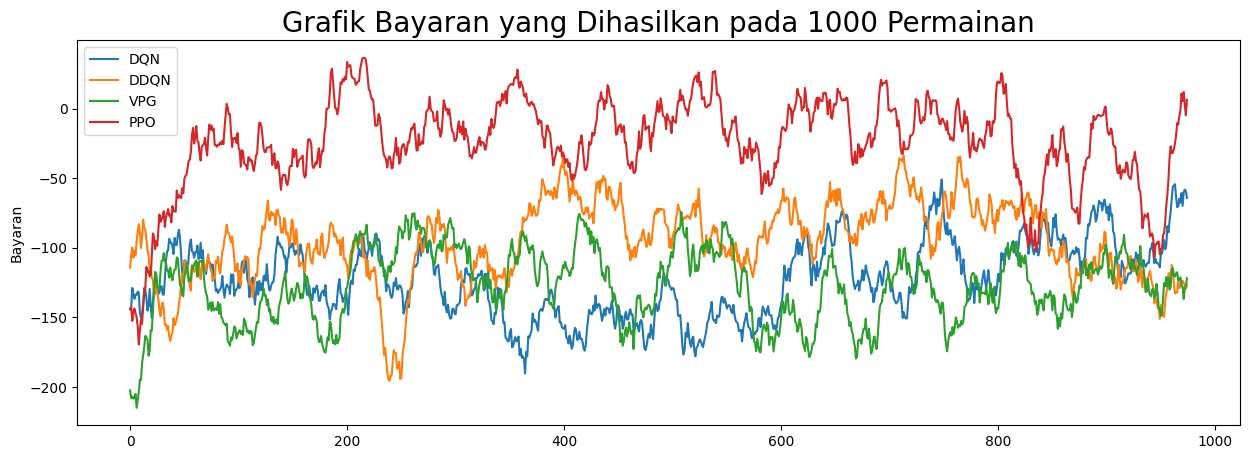

In [ ]:
batch_len = 20
average = []
for i in range((len(total_reward))//batch_len):
    sum = 0
    for j in range(batch_len):
        sum += total_reward[i*batch_len+j]
    average.append(sum/batch_len)

move_len = 25
m_average = []
for i in range((len(total_reward))-move_len):
    sum = 0
    for j in range(move_len):
        sum += total_reward[i+j]
    m_average.append(sum/move_len)

average_mean = []
for i in range((len(data))//batch_len):
    average_mean.append(np.mean(data[i*batch_len:(i+1)*batch_len]))

average_loss = []
for i in range((len(loss))//batch_len):
    sum = 0
    for j in range(batch_len):
        sum += loss[i*batch_len+j][1]
    average_loss.append(sum/batch_len)

plt.figure(figsize=(15, 5))
plt.title("Grafik Bayaran yang Dihasilkan pada 1000 Permainan", fontsize=20)
plt.ylabel("Bayaran")
x = [i*batch_len for i in range(int(1000/batch_len))]
plt.plot(m_average)
plt.legend(['DQN','DDQN','VPG','PPO','Average'])
plt.show()

In [ ]:
weights, biases = env.agent[3].model.layers[0].get_weights()
print(weights)
print(biases)

[[-0.16262726 -0.2755398  -0.11971756 ... -0.10498045  0.21548878
  -0.09757217]
 [-0.06031602 -0.1155493  -0.11721695 ... -0.1858905   0.10209077
   0.04440189]
 [ 0.20827888  0.12064847 -0.11726154 ...  0.01639524  0.05355832
  -0.01088946]
 ...
 [ 0.02155881  0.07277361 -0.0666206  ...  0.08887952 -0.03702456
   0.07634348]
 [ 0.14343444  0.11623432  0.02557153 ...  0.09695516  0.08746815
   0.01404956]
 [-0.06233042  0.00299217  0.01677337 ... -0.07029016 -0.09103741
  -0.0720887 ]]
[ 0.07534508  0.0706759  -0.02938113  0.06984383  0.06937349 -0.02274024
  0.02673987  0.06693289 -0.02733912  0.05292641  0.04052684  0.02101041
  0.02965485  0.00267161  0.05846471  0.00063458  0.07010784  0.04222202
  0.04608368  0.03036533 -0.02342375  0.02767776  0.04629741 -0.03563331
 -0.03172102  0.09076812  0.036227    0.02231131 -0.04028136  0.06497499
  0.02051627 -0.01066329]


In [ ]:
weights, biases = env.agent[3].model_set[0][0].layers[0].get_weights()
print(weights)
print(biases)

[[-0.16262726 -0.2755398  -0.11971756 ... -0.10498045  0.21548878
  -0.09757217]
 [-0.06031602 -0.1155493  -0.11721695 ... -0.1858905   0.10209077
   0.04440189]
 [ 0.20827888  0.12064847 -0.11726154 ...  0.01639524  0.05355832
  -0.01088946]
 ...
 [ 0.02155881  0.07277361 -0.0666206  ...  0.08887952 -0.03702456
   0.07634348]
 [ 0.14343444  0.11623432  0.02557153 ...  0.09695516  0.08746815
   0.01404956]
 [-0.06233042  0.00299217  0.01677337 ... -0.07029016 -0.09103741
  -0.0720887 ]]
[ 0.07534508  0.0706759  -0.02938113  0.06984383  0.06937349 -0.02274024
  0.02673987  0.06693289 -0.02733912  0.05292641  0.04052684  0.02101041
  0.02965485  0.00267161  0.05846471  0.00063458  0.07010784  0.04222202
  0.04608368  0.03036533 -0.02342375  0.02767776  0.04629741 -0.03563331
 -0.03172102  0.09076812  0.036227    0.02231131 -0.04028136  0.06497499
  0.02051627 -0.01066329]


# Archive